## Run all import statements

In [38]:
#!jupyter nbconvert --to script pythiaTesting.ipynb
#import ROOT
#import uproot as ur
import numpy as np
import pandas as pd
from particle import Particle
from particle import PythiaID
from particle import PDGID
from particle.converters import Pythia2PDGIDBiMap
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, DelphesSchema
import qgrid
#import networkx as nx
#import pydot
#from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
#import pyarrow as pa
#import urllib.request

## Helper functions

In [39]:
def getEvents(filedir, filename, treename):
    return NanoEventsFactory.from_root(filedir + filename, treepath = treename, schemaclass = DelphesSchema).events()

## Imports the four MC gen level data into awkward datasets

In [40]:
filedir   = "root://cms-xrd-global.cern.ch//store/user/christiw/BDecay_delphes/v1/"
filenames = ["m1_ct10000mm.root", "m1_ct1000mm.root", "m1_ct100mm.root", "m1_ct10mm.root"]
treename  = "Delphes"


ct_10000 = getEvents(filedir, filenames[0], treename)
ct_1000  = getEvents(filedir, filenames[1], treename)
ct_100   = getEvents(filedir, filenames[2], treename)
ct_10    = getEvents(filedir, filenames[3], treename)

## B hadrons (both legs), energy, pt, eta, phi

### ct_10000

/tmp/ipykernel_10497/843980183.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))


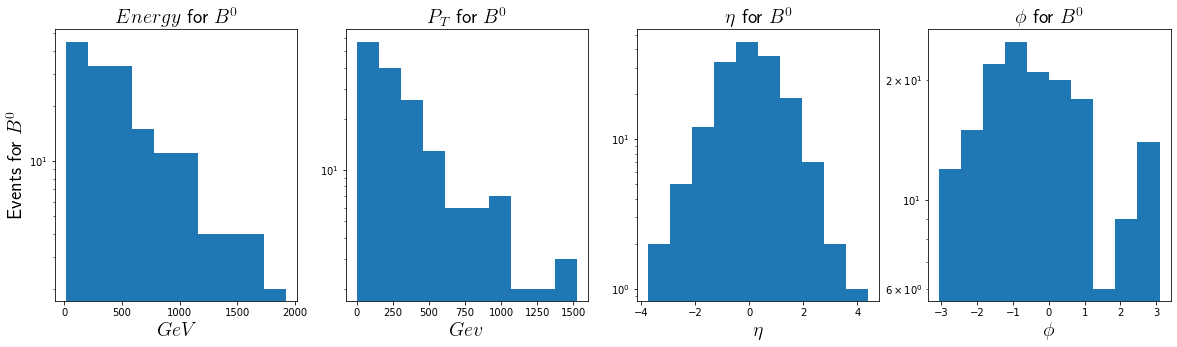

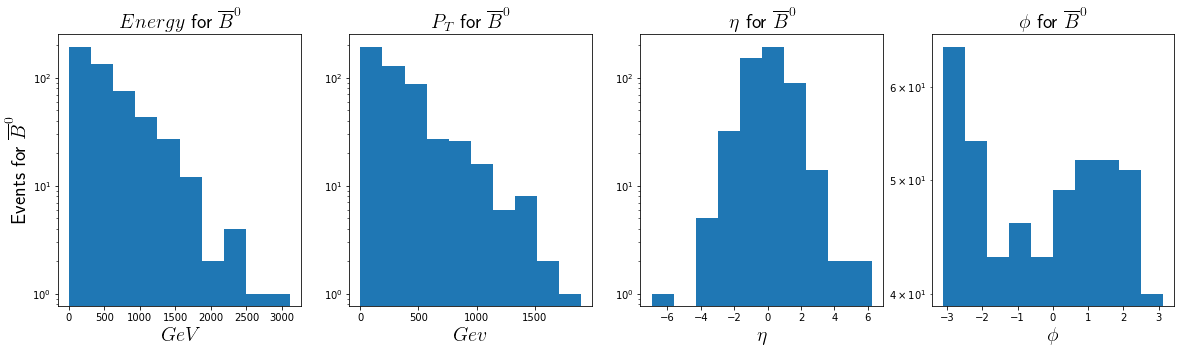

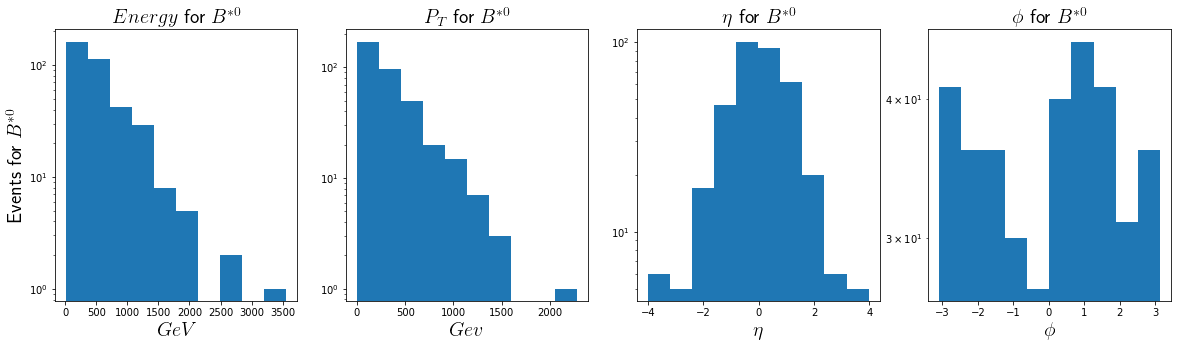

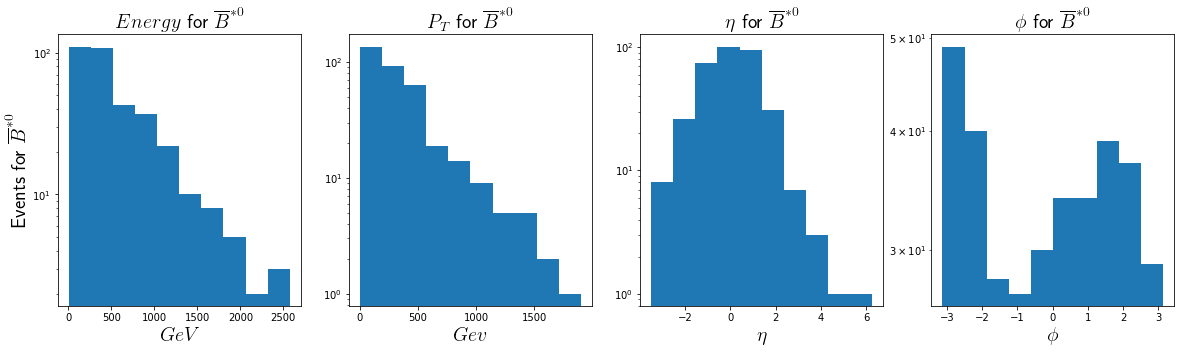

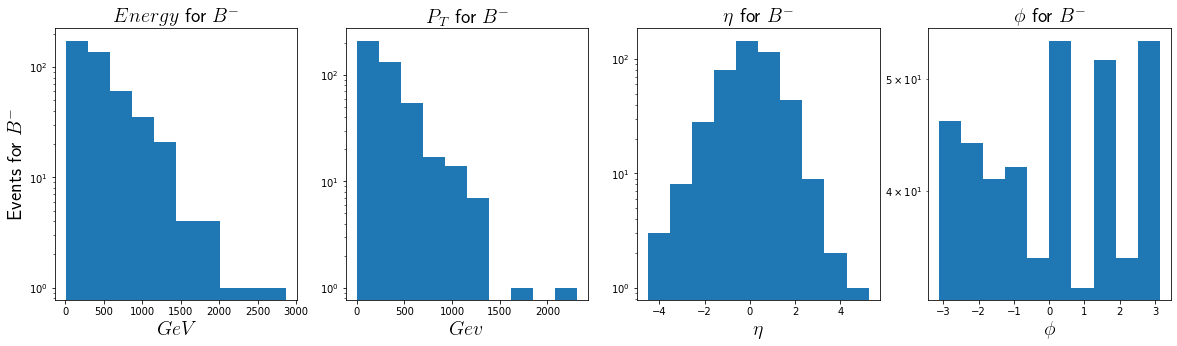

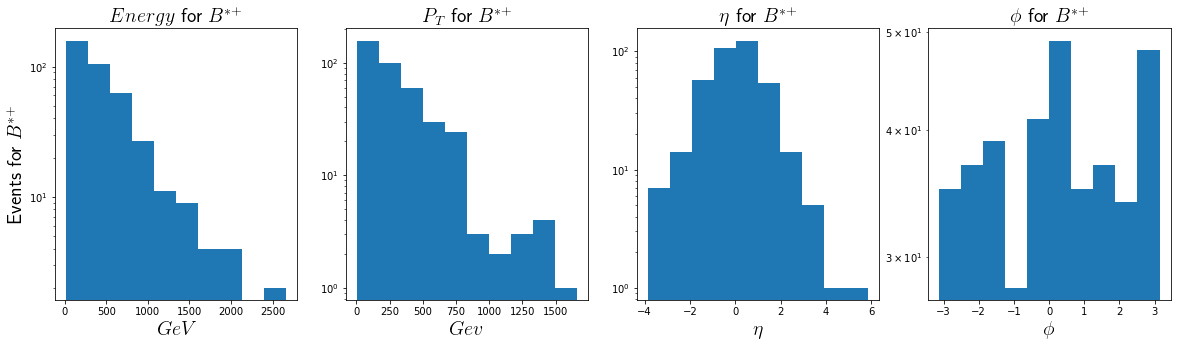

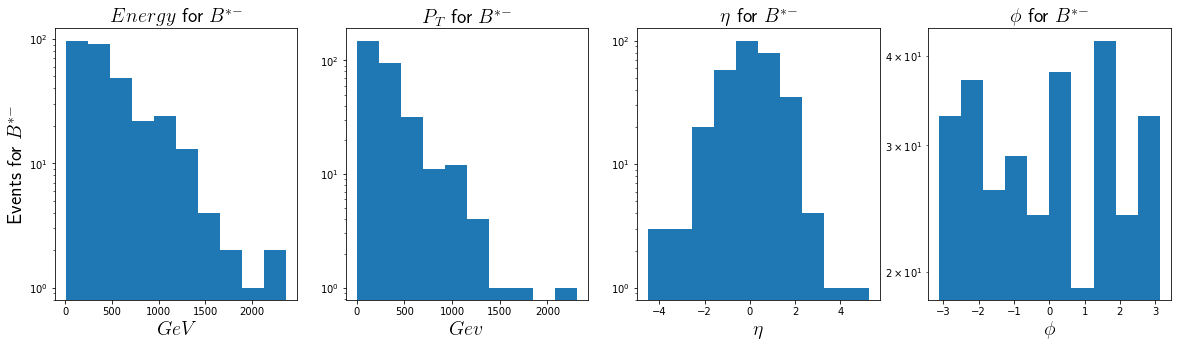

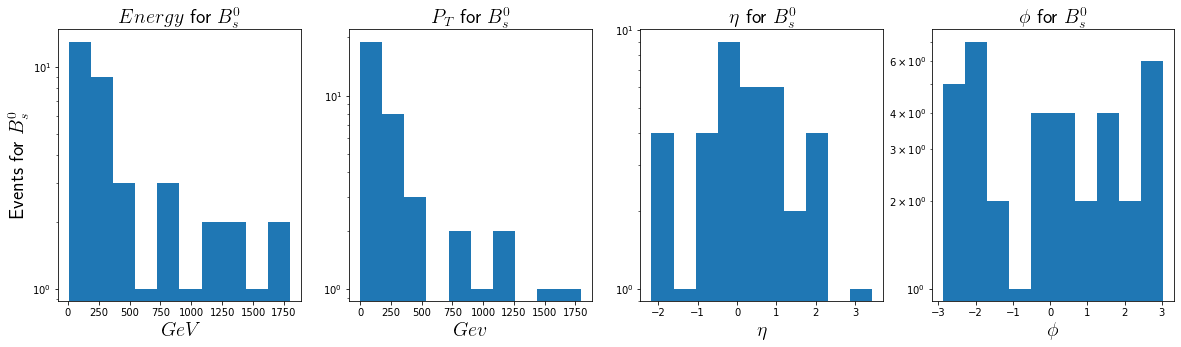

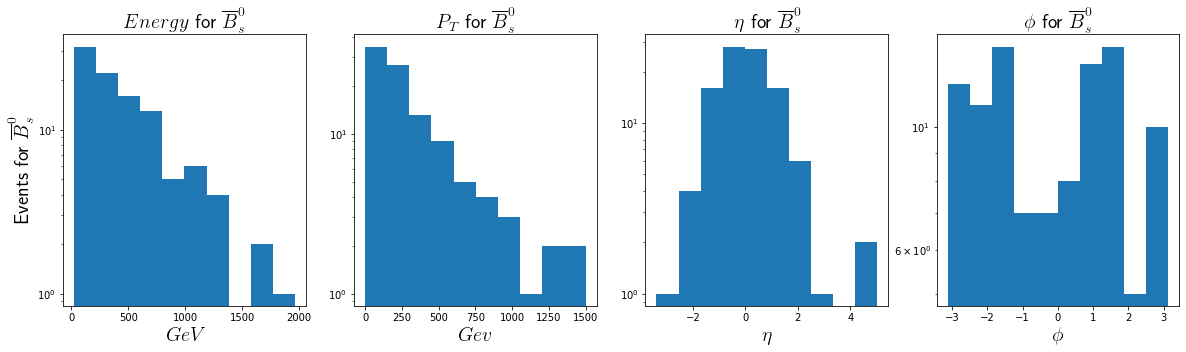

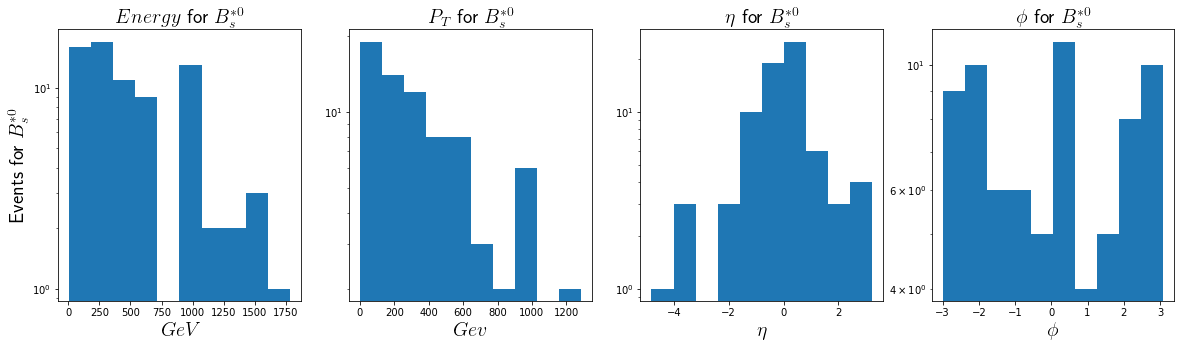

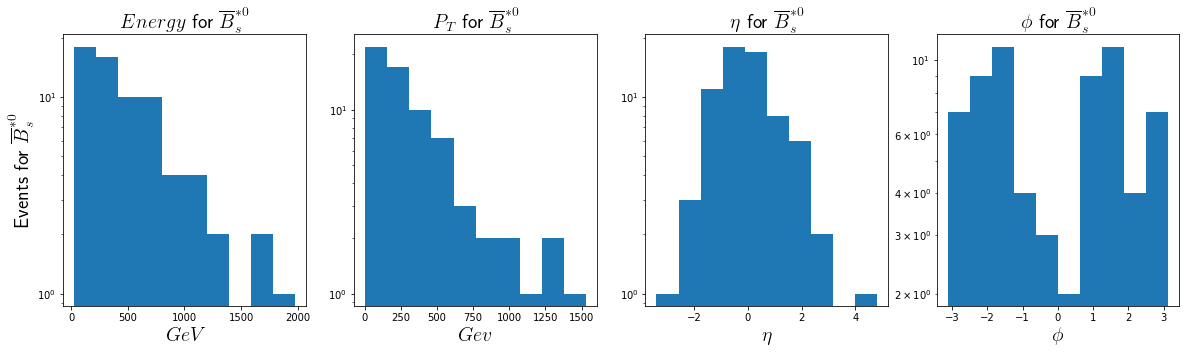

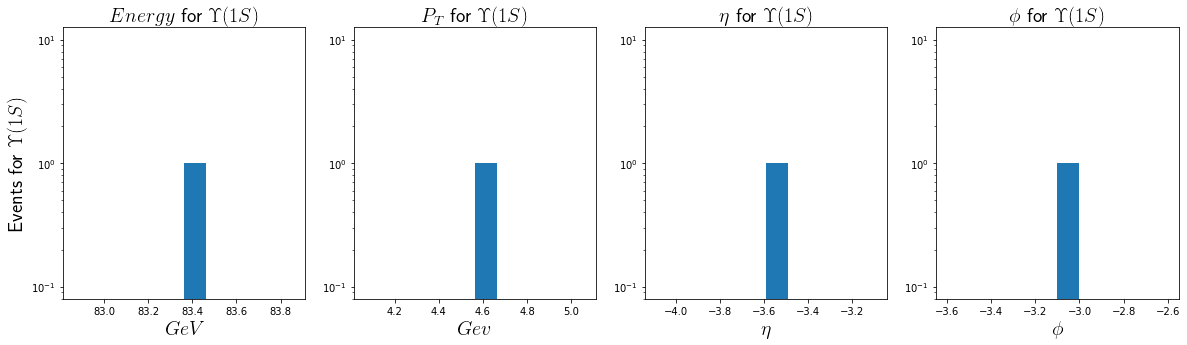

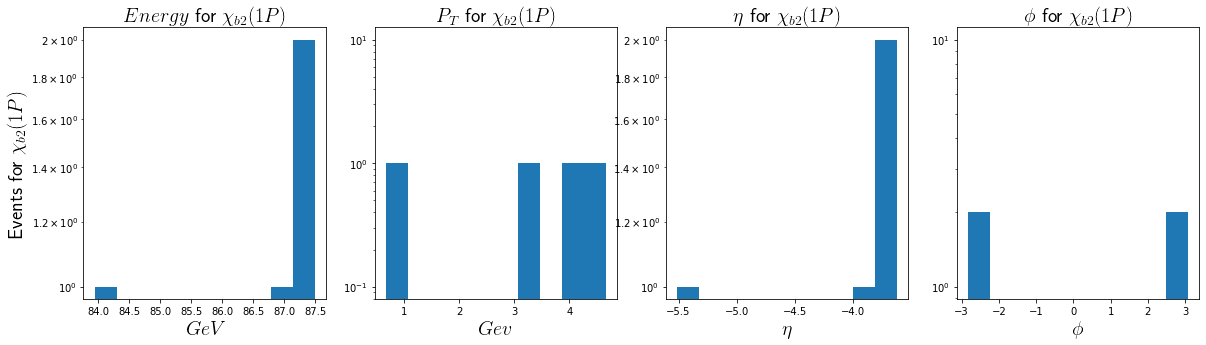

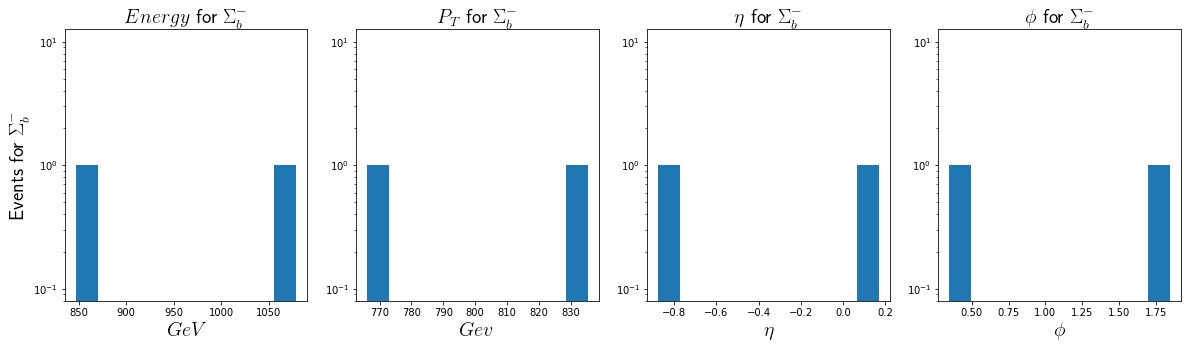

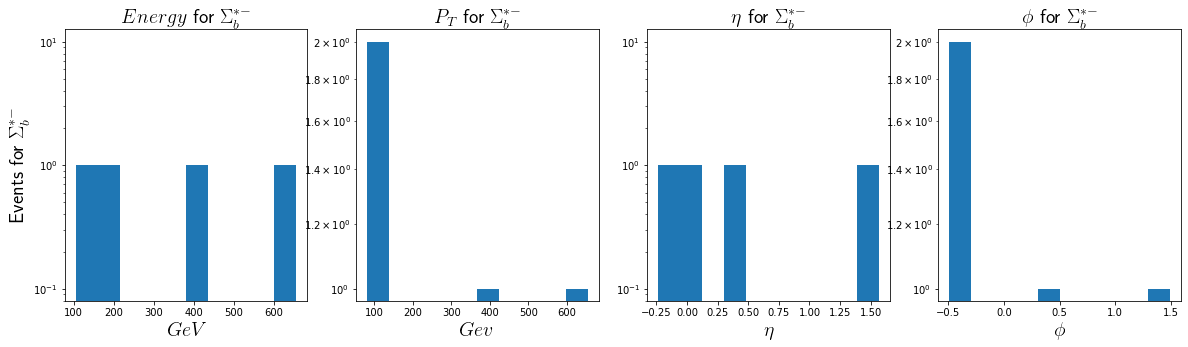

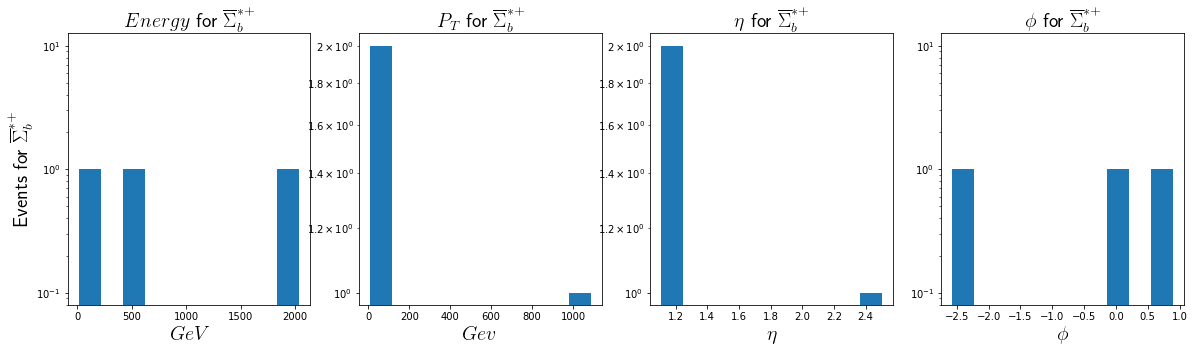

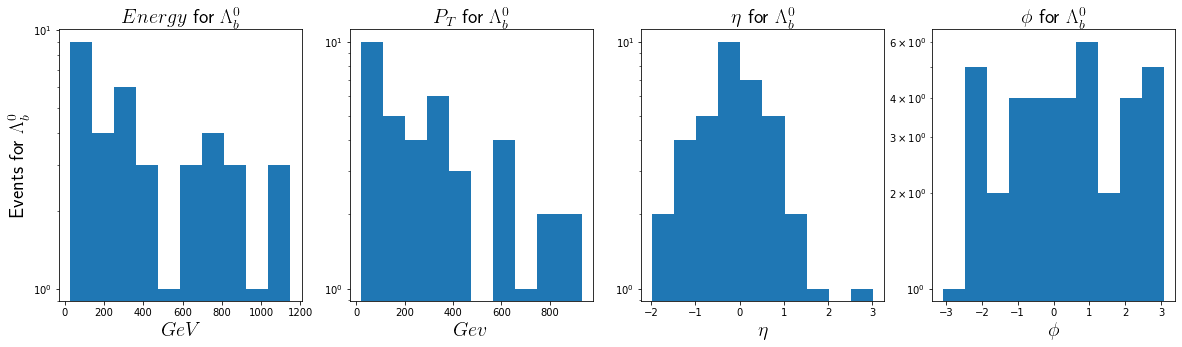

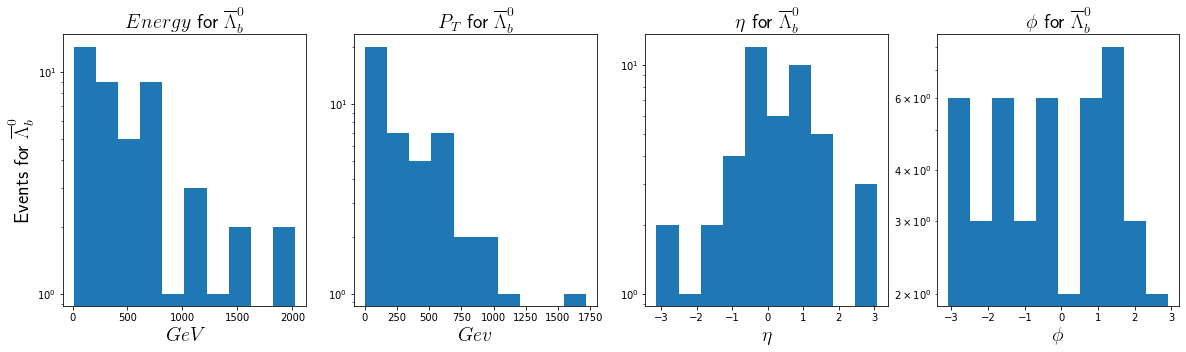

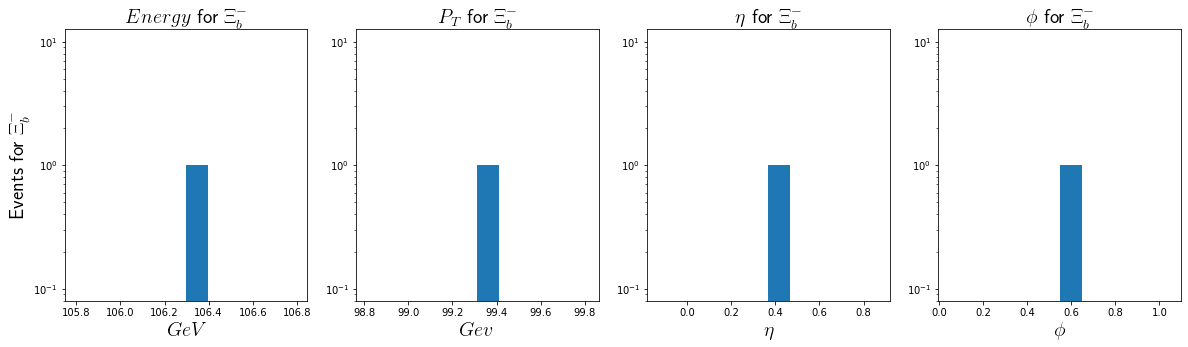

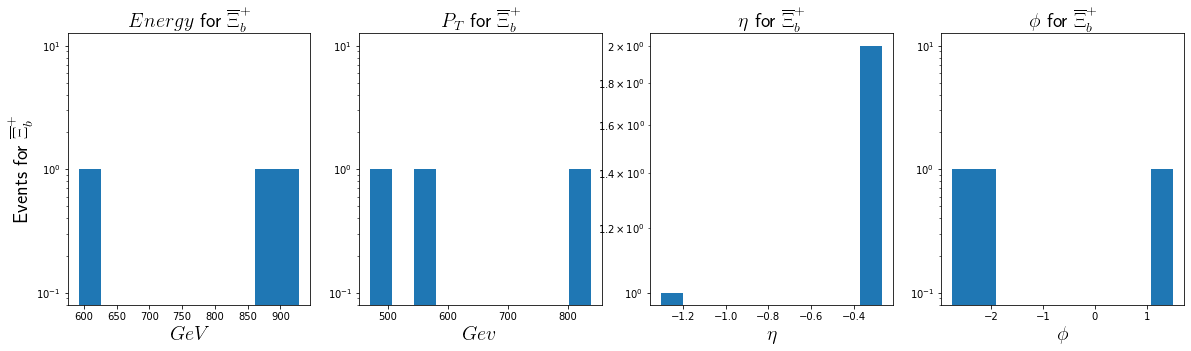

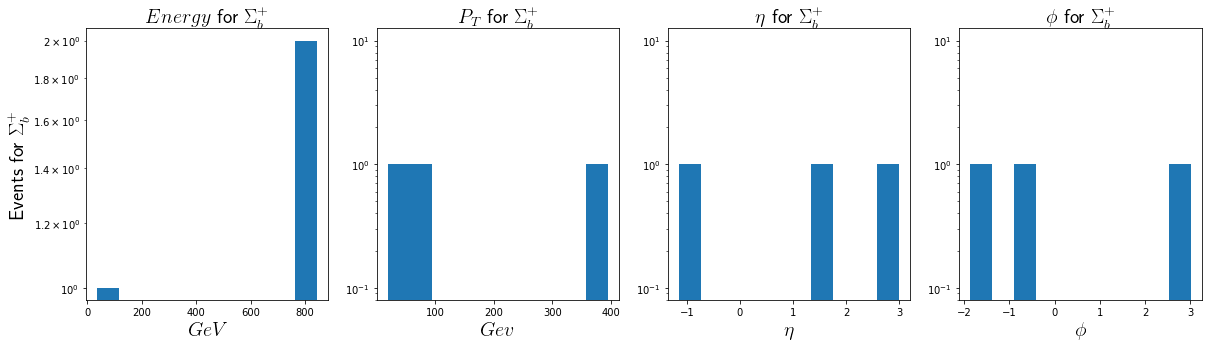

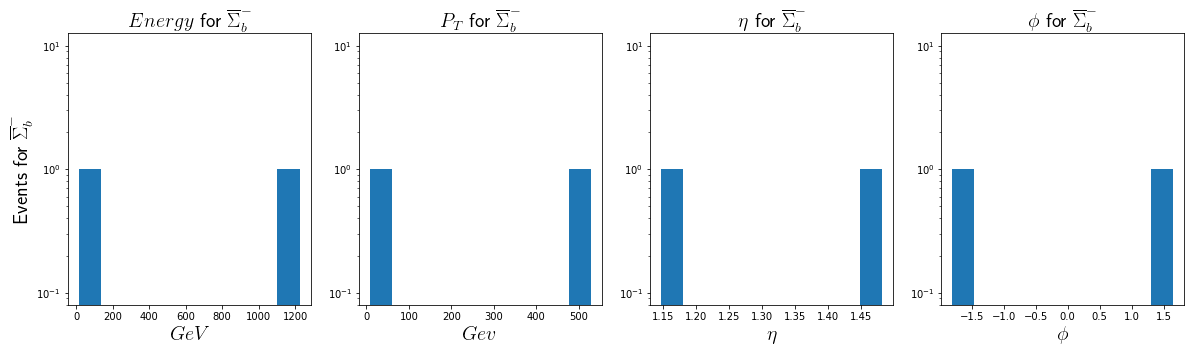

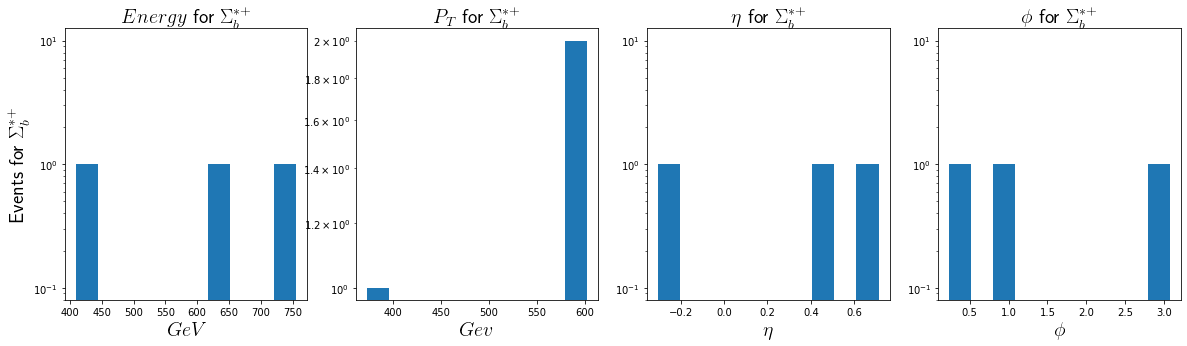

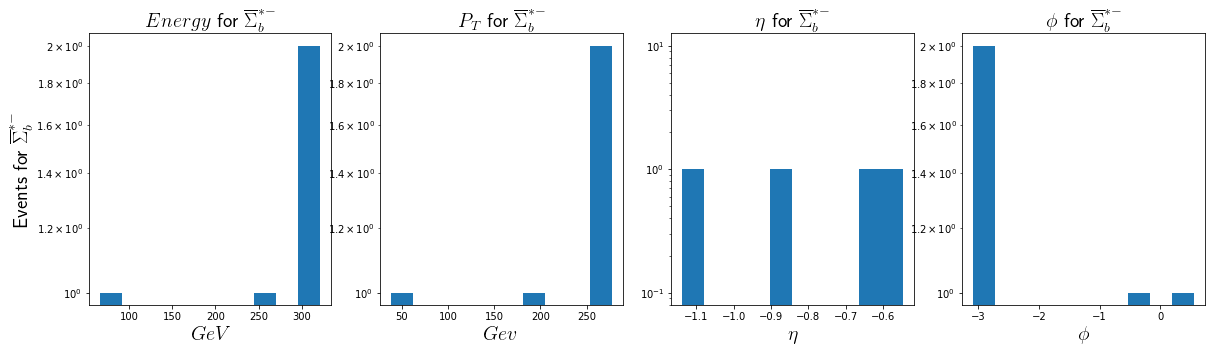

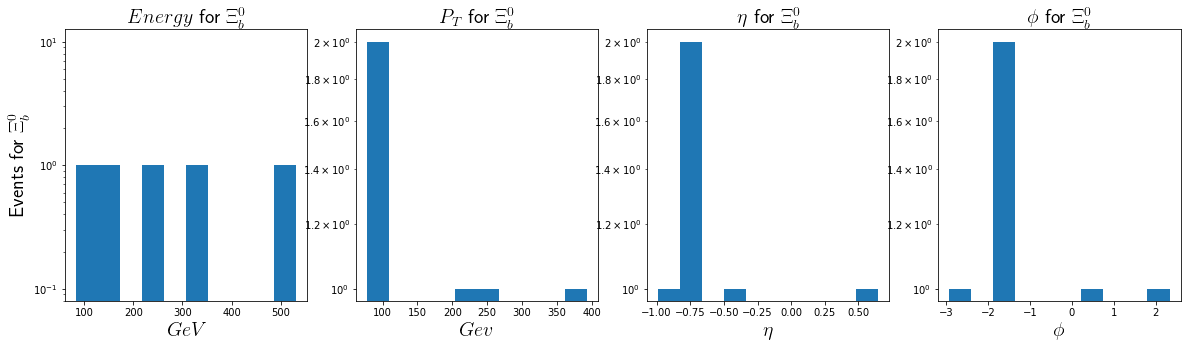

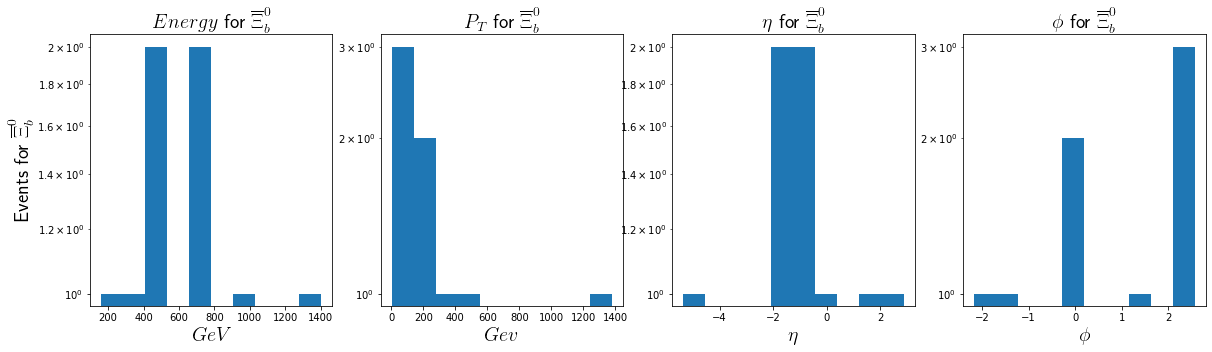

In [41]:
pdgids = list(map(lambda a: int(a.pdgid), Particle.finditer(lambda p: p.pdgid.is_hadron and (p.pdgid.has_bottom)))) #really fucky way of getting pids of B mesons
ctawk = ct_10000.Particle

fields = ["E", "PT", "Eta", "Phi"]
x_axis = ["$GeV$", "$Gev$", "$\eta$", "$\phi$"]
titles = ["$Energy$ for ", "$P_{T}$ for ", "$\eta$ for ", "$\phi$ for "]

for pdgid in pdgids:
    mask = (ctawk.PID == pdgid)
    if ak.sum(mask) != 0:
        fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))
        fig[1][0].set_ylabel('Events for ' + '$' + Particle.from_pdgid(PDGID(pdgid)).latex_name + '$', usetex = True, fontsize = 20)
        for i in range(len(fields)):
            fig[1][i].hist(ak.flatten(ctawk[mask][fields[i]]), log = True)
            fig[1][i].set_title(titles[i] + ' $' + Particle.from_pdgid(PDGID(pdgid)).latex_name + '$', usetex = True, fontsize = 20)
            fig[1][i].set_xlabel(x_axis[i], fontsize = 20, usetex = True)
            #fig[1][i].set_ylim([0, 1])
        fig[0].show()


### ct_1000

/tmp/ipykernel_10497/2567120845.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))


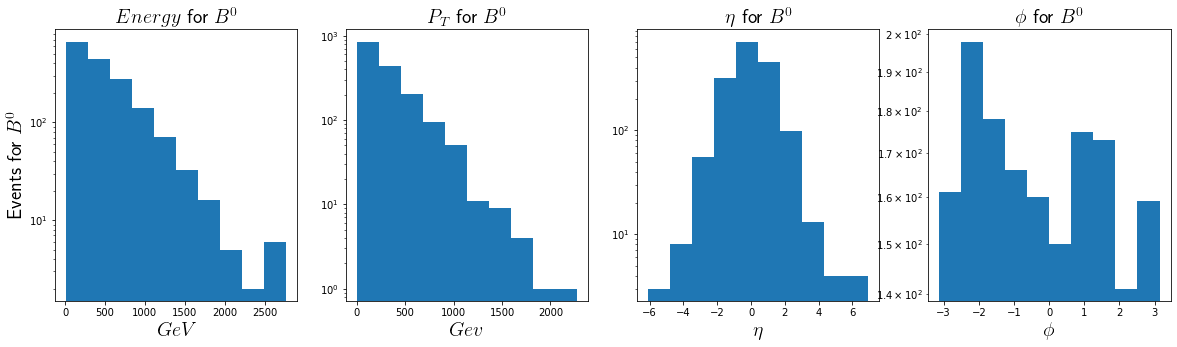

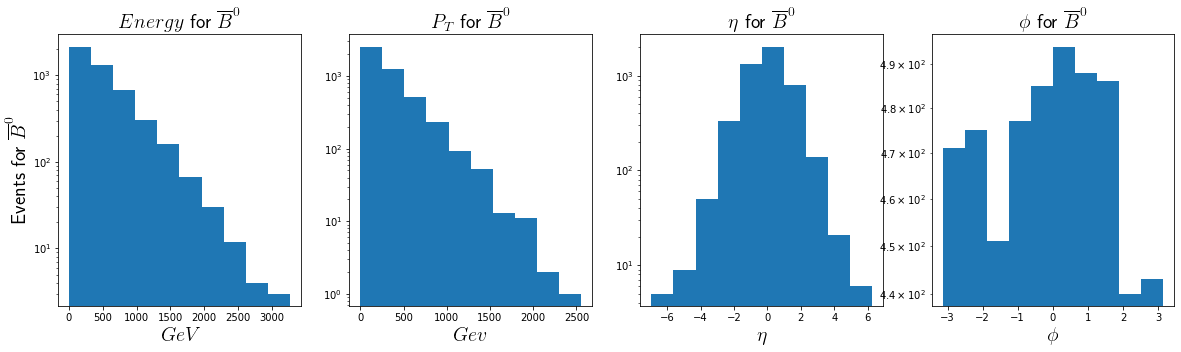

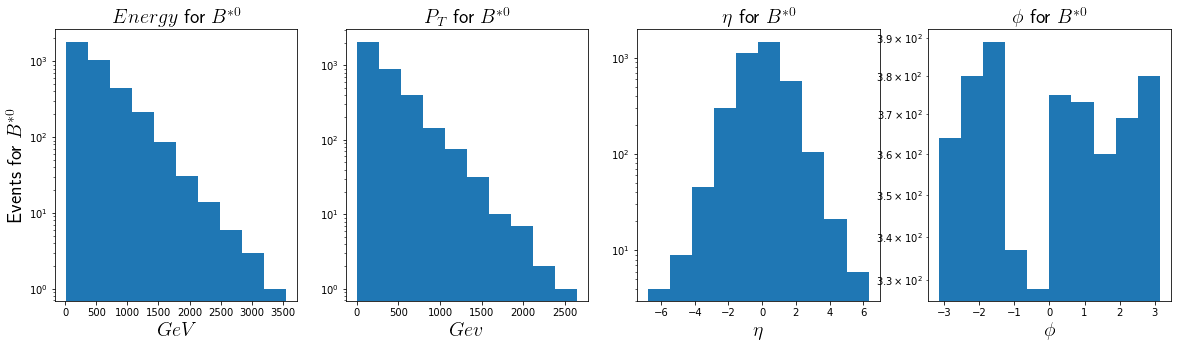

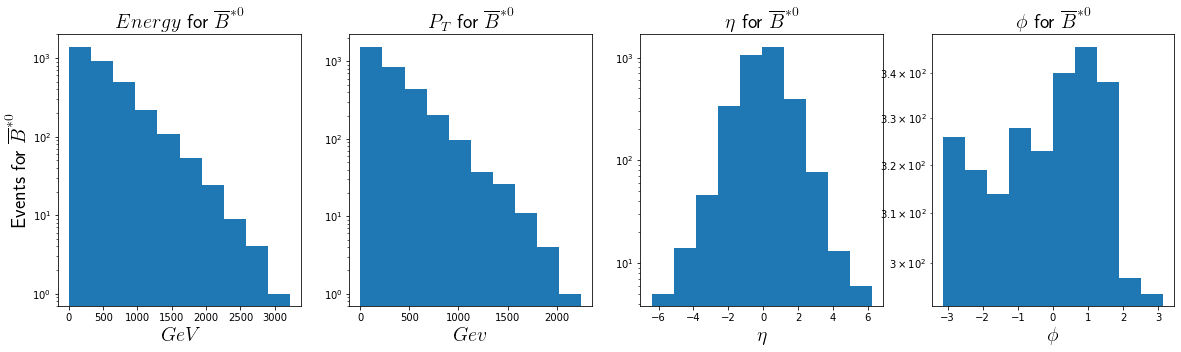

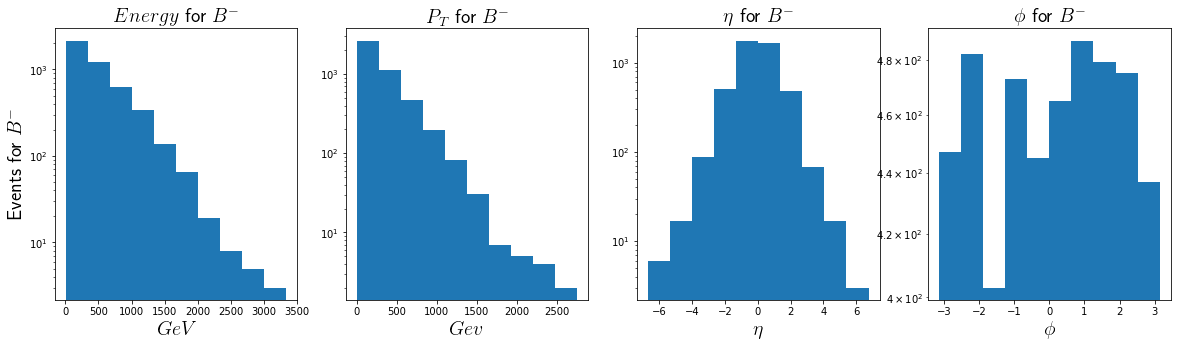

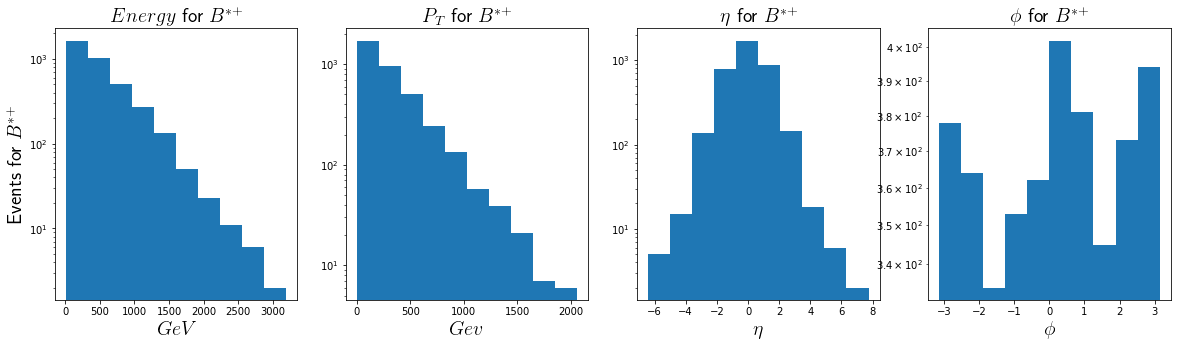

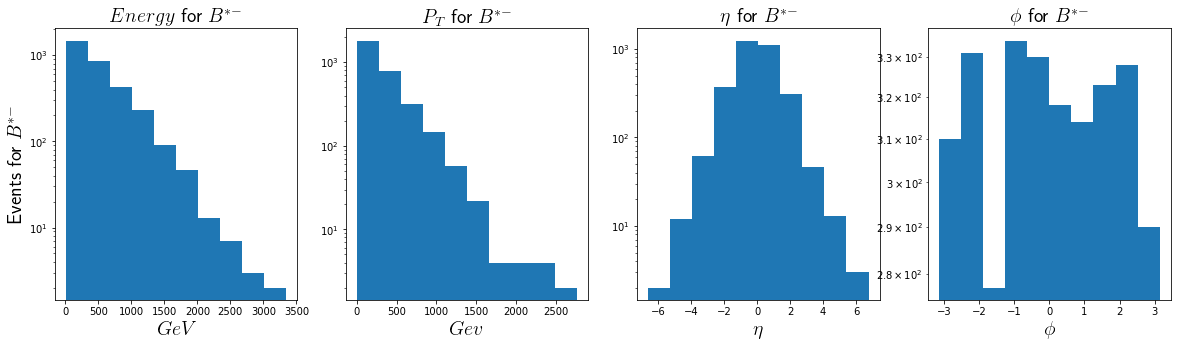

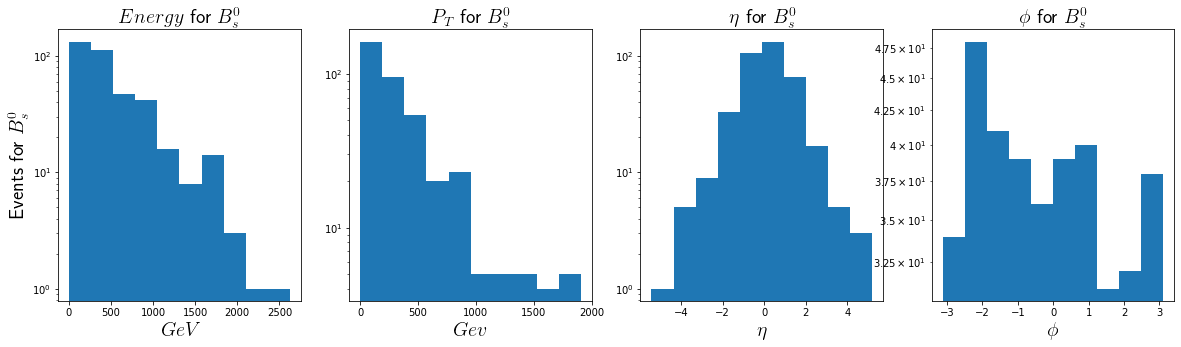

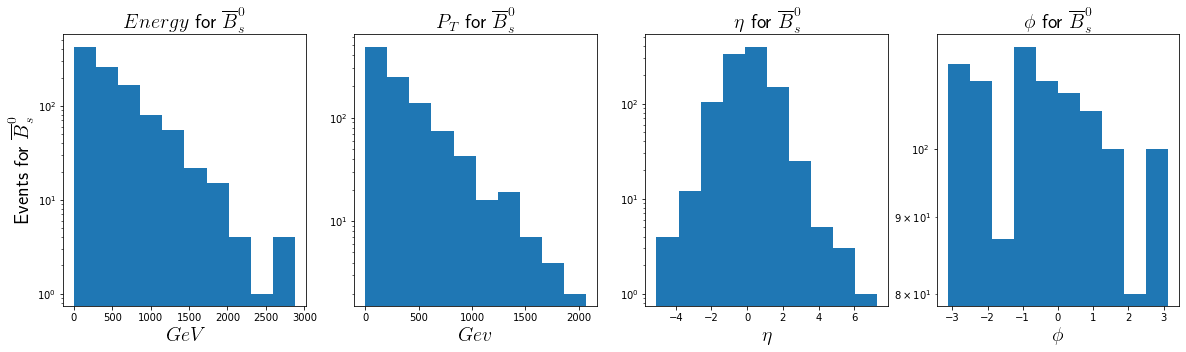

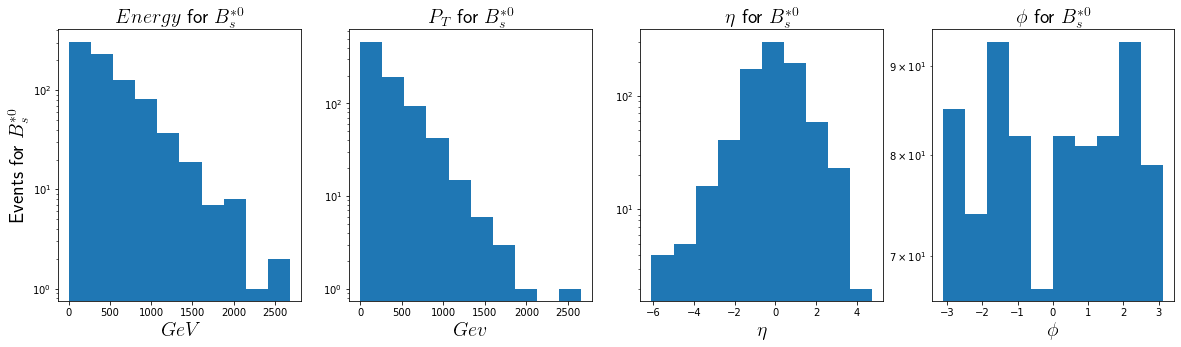

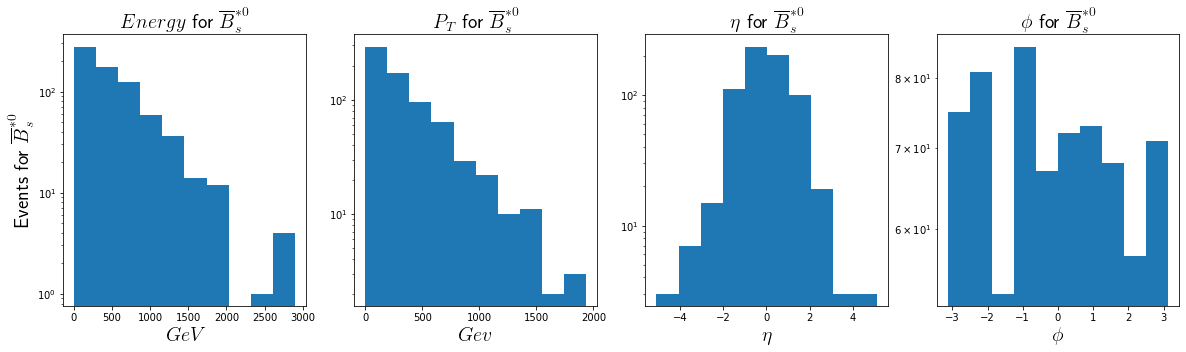

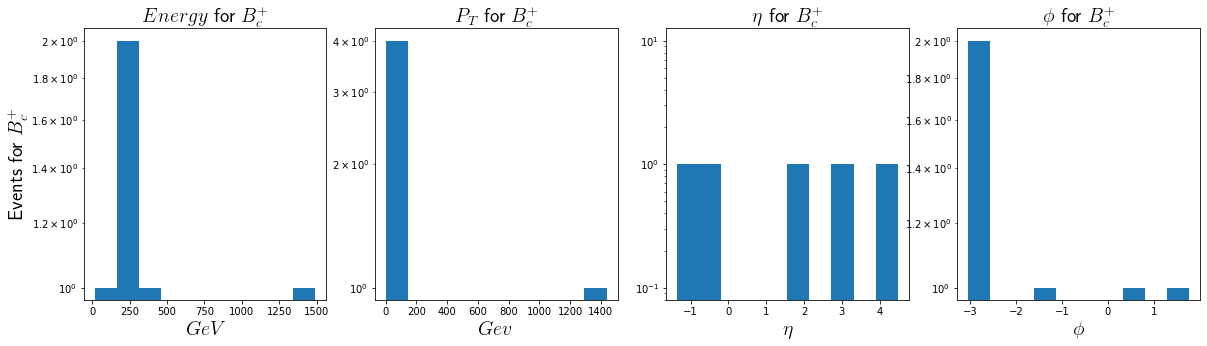

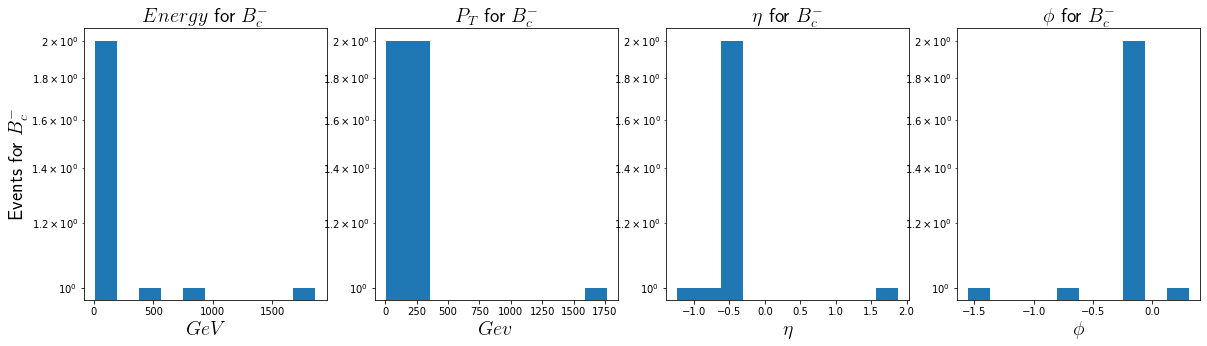

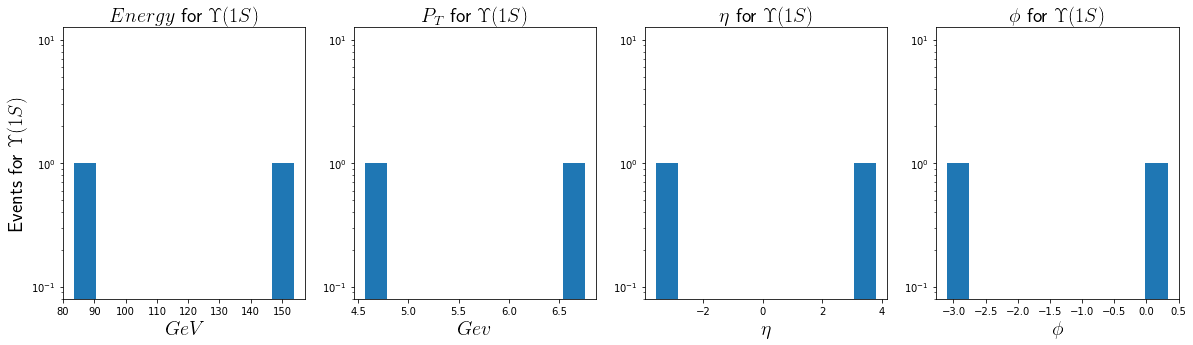

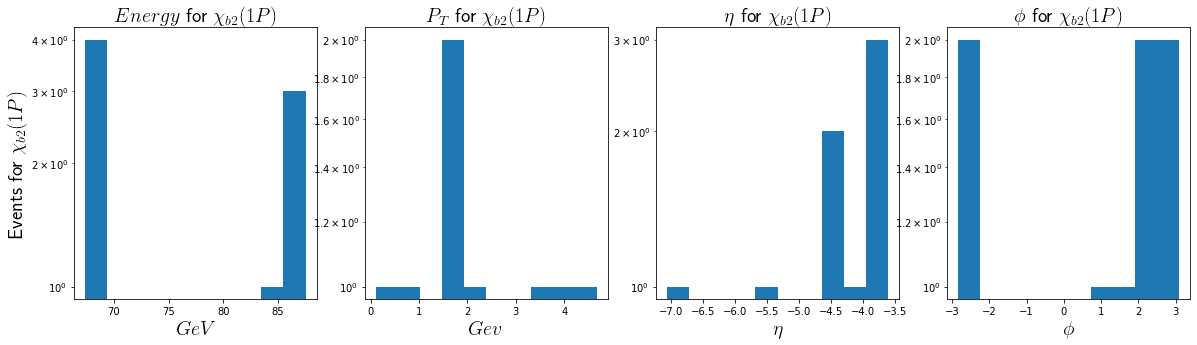

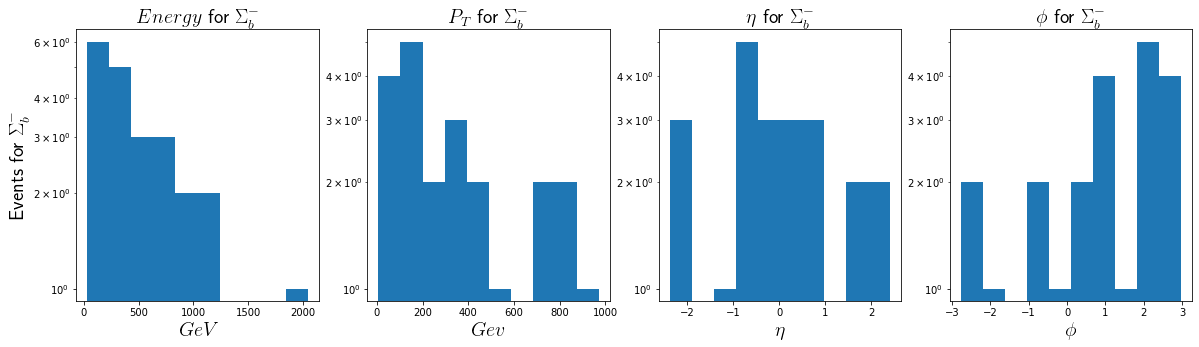

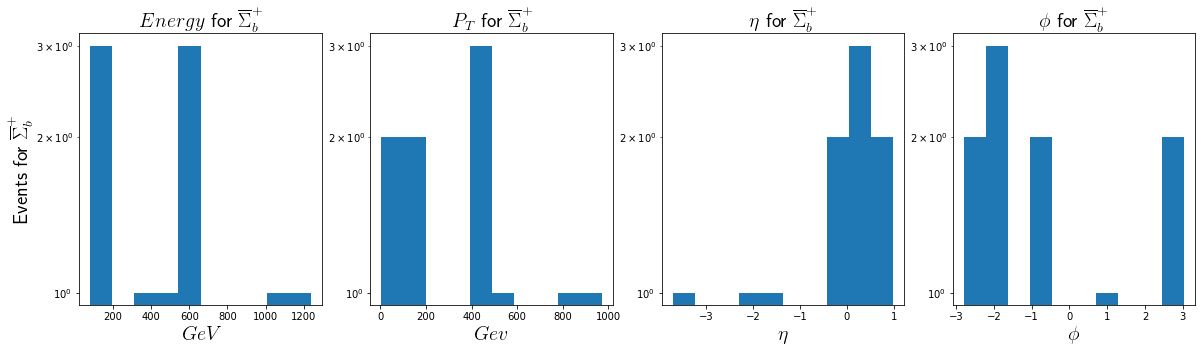

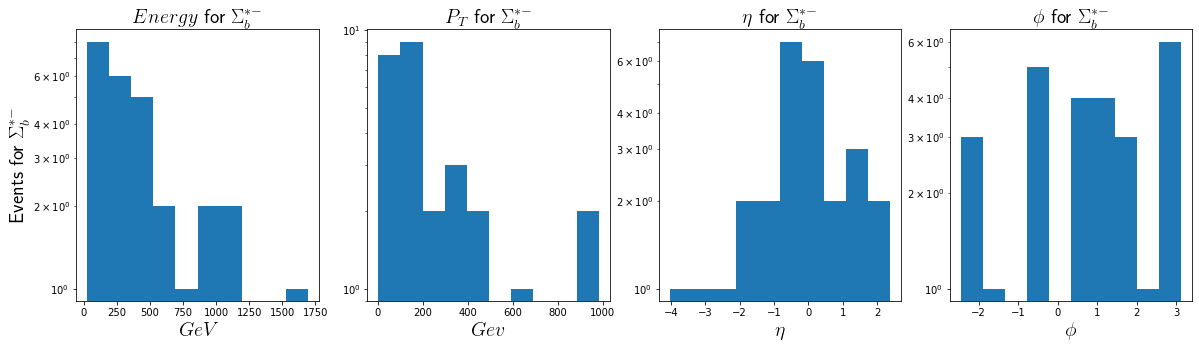

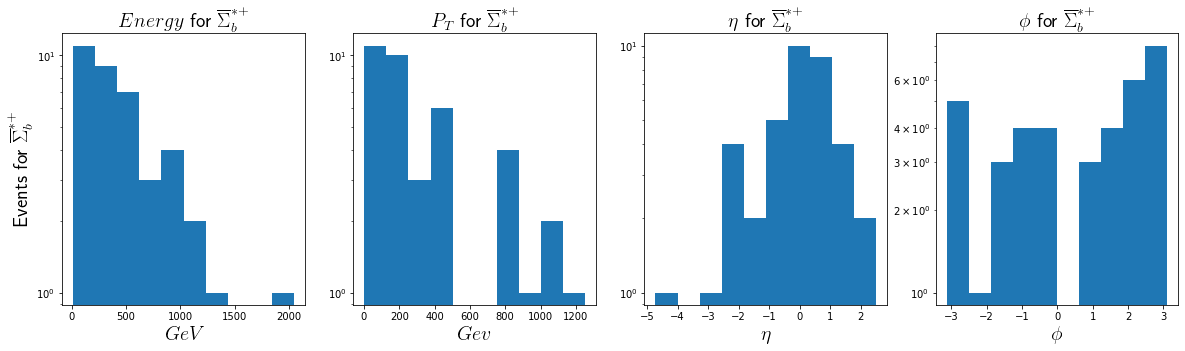

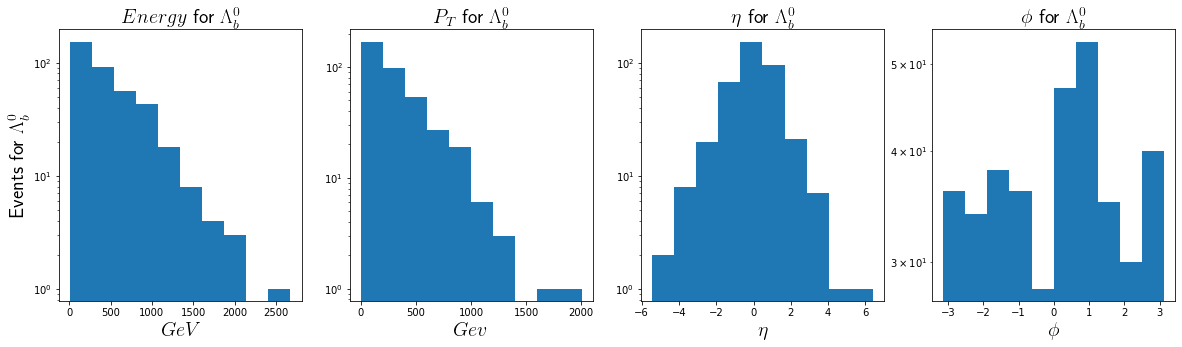

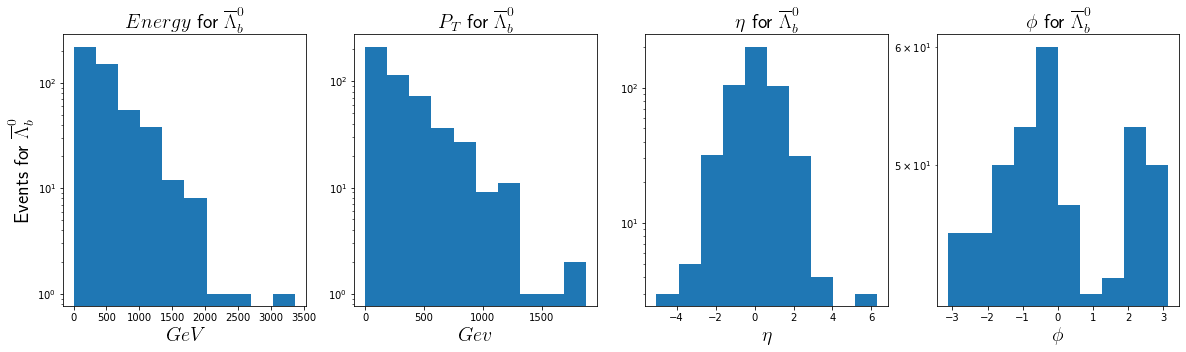

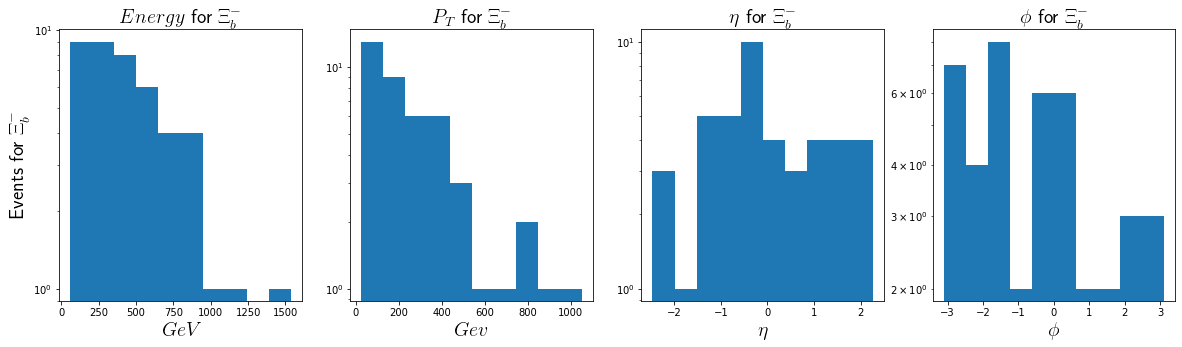

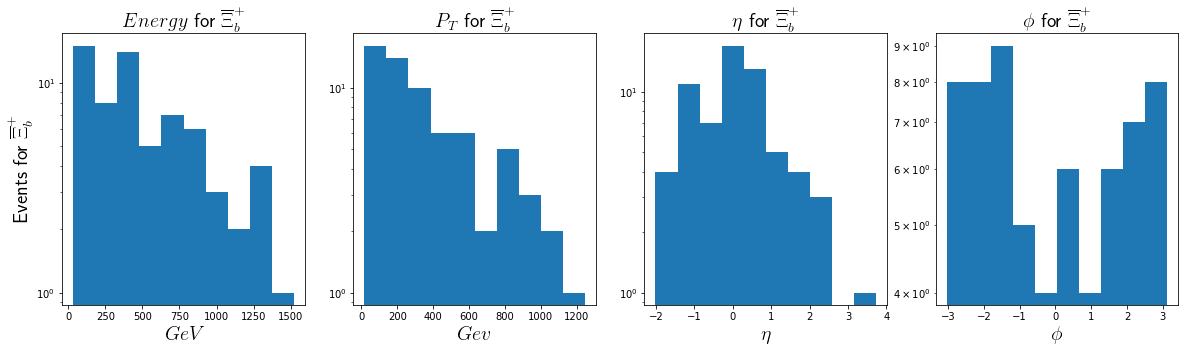

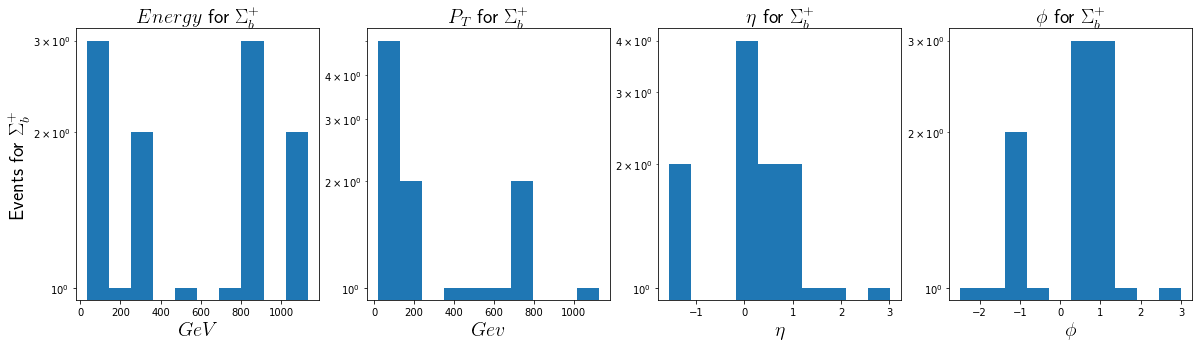

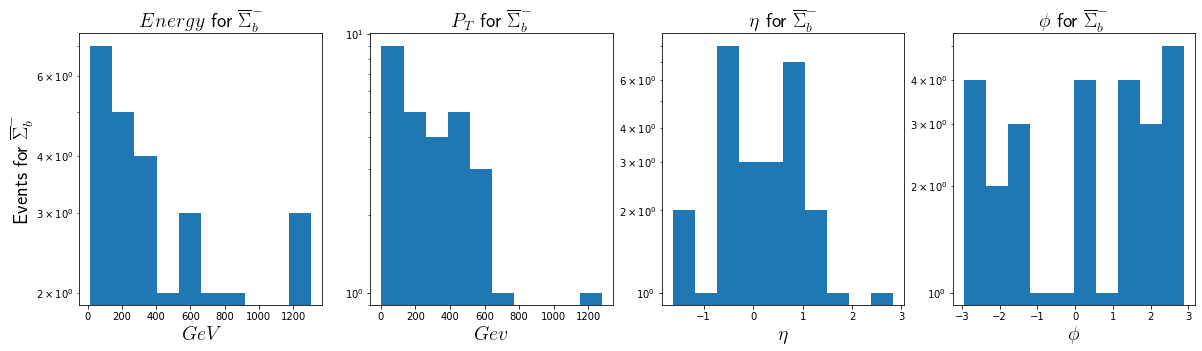

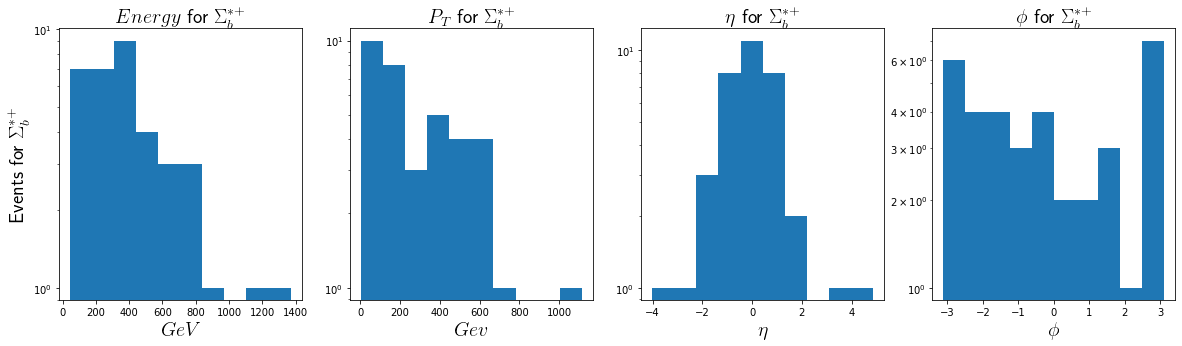

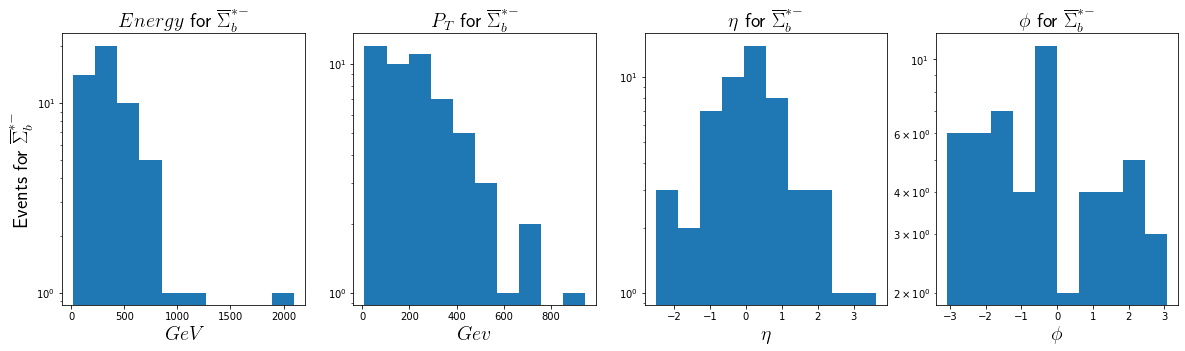

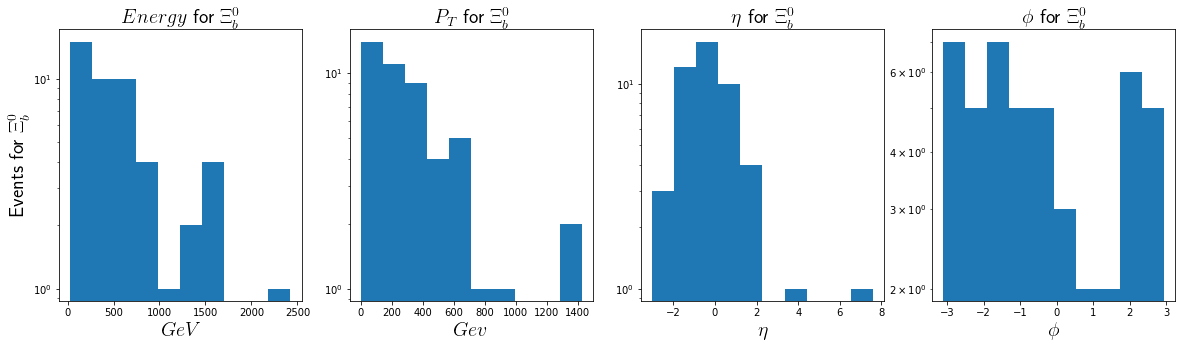

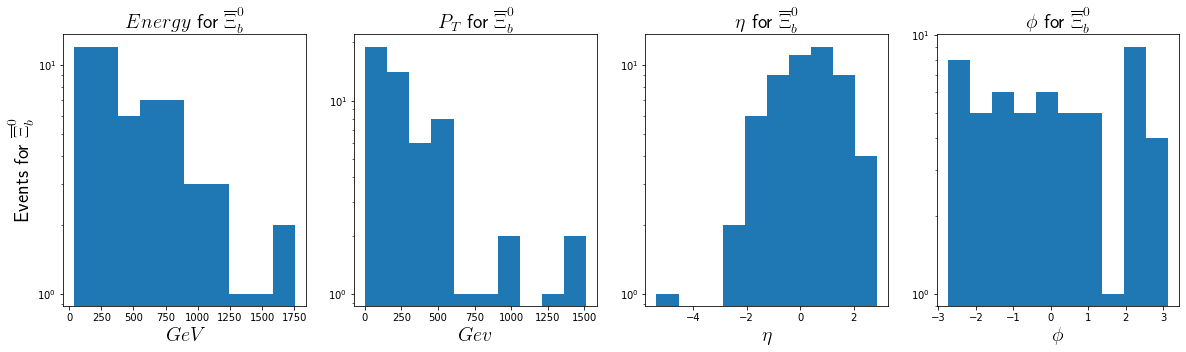

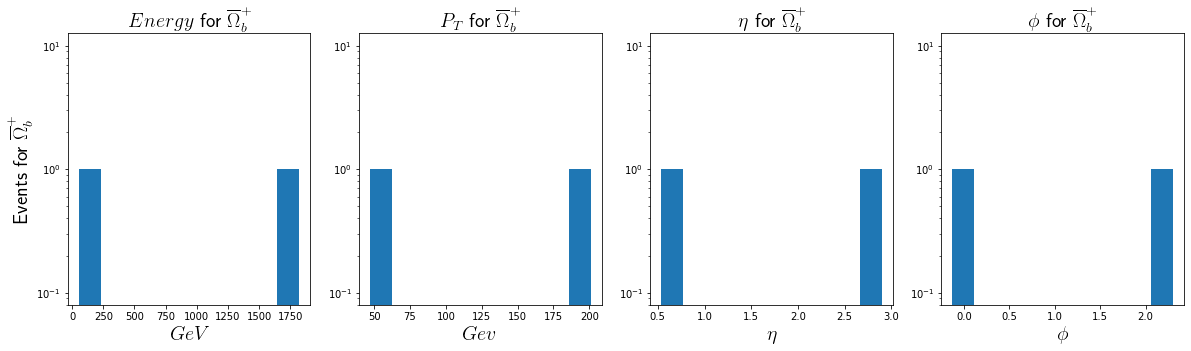

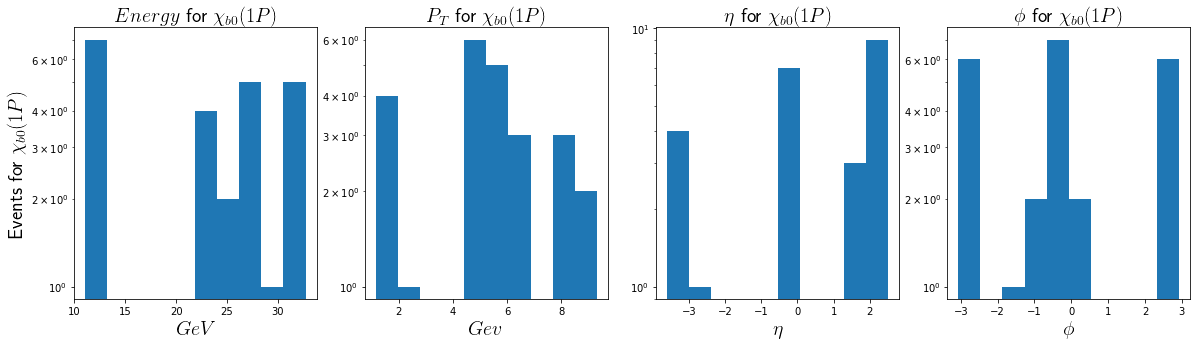

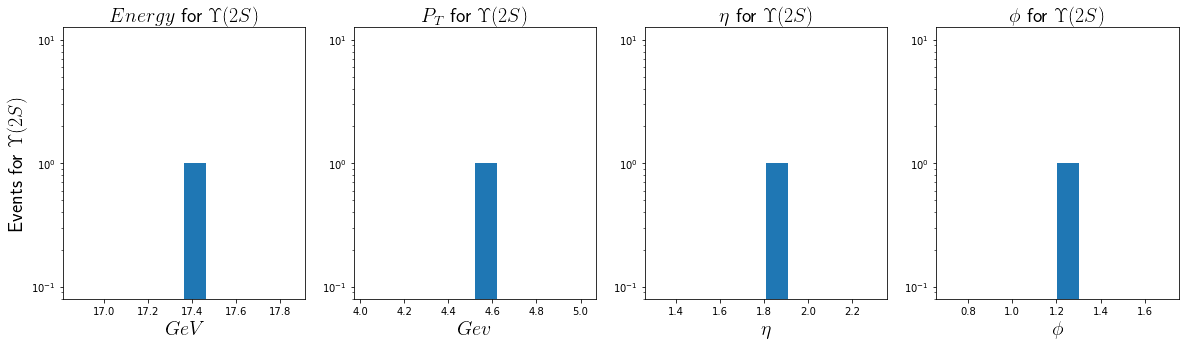

In [42]:
pdgids = list(map(lambda a: int(a.pdgid), Particle.finditer(lambda p: p.pdgid.is_hadron and (p.pdgid.has_bottom)))) #really fucky way of getting pids of B mesons
ctawk = ct_1000.Particle

fields = ["E", "PT", "Eta", "Phi"]
x_axis = ["$GeV$", "$Gev$", "$\eta$", "$\phi$"]
titles = ["$Energy$ for ", "$P_{T}$ for ", "$\eta$ for ", "$\phi$ for "]

for pdgid in pdgids:
    mask = (ctawk.PID == pdgid)
    if ak.sum(mask) != 0:
        fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))
        fig[1][0].set_ylabel('Events for ' + '$' + Particle.from_pdgid(PDGID(pdgid)).latex_name + '$', usetex = True, fontsize = 20)
        for i in range(len(fields)):
            fig[1][i].hist(ak.flatten(ctawk[mask][fields[i]]), log = True)
            fig[1][i].set_title(titles[i] + ' $' + Particle.from_pdgid(PDGID(pdgid)).latex_name + '$', usetex = True, fontsize = 20)
            fig[1][i].set_xlabel(x_axis[i], fontsize = 20, usetex = True)
            #fig[1][i].set_ylim([0, 1])
        fig[0].show()


### ct_100

/tmp/ipykernel_10497/3941299618.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))


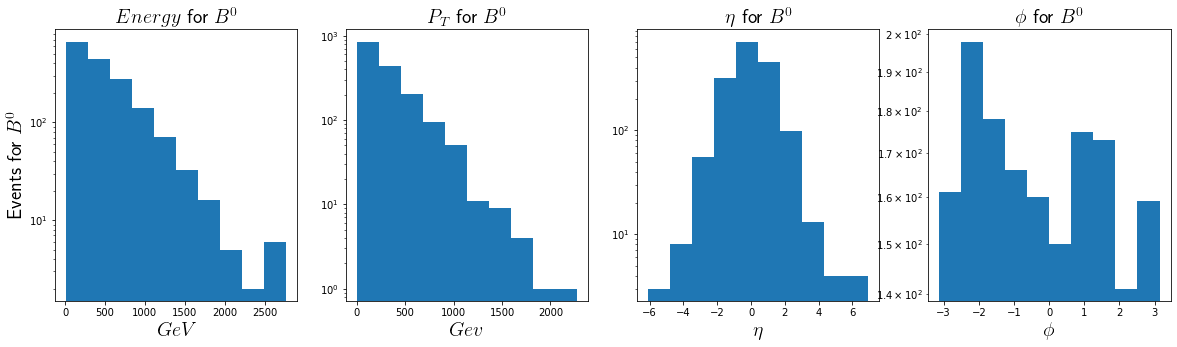

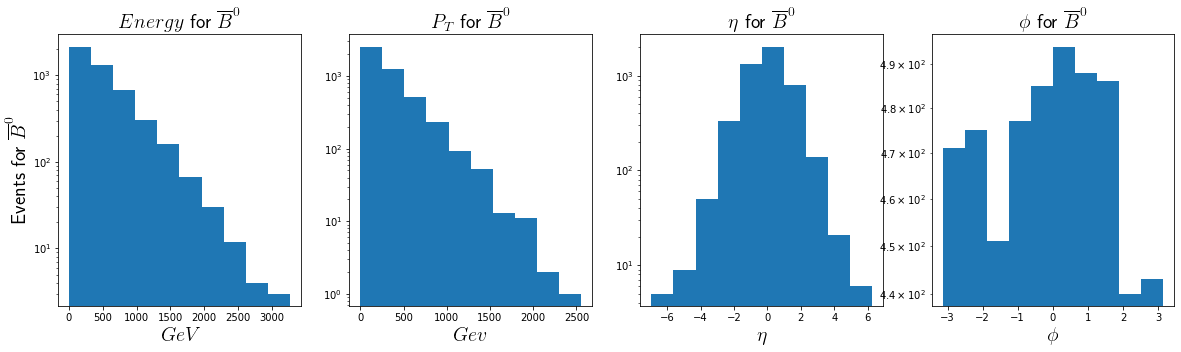

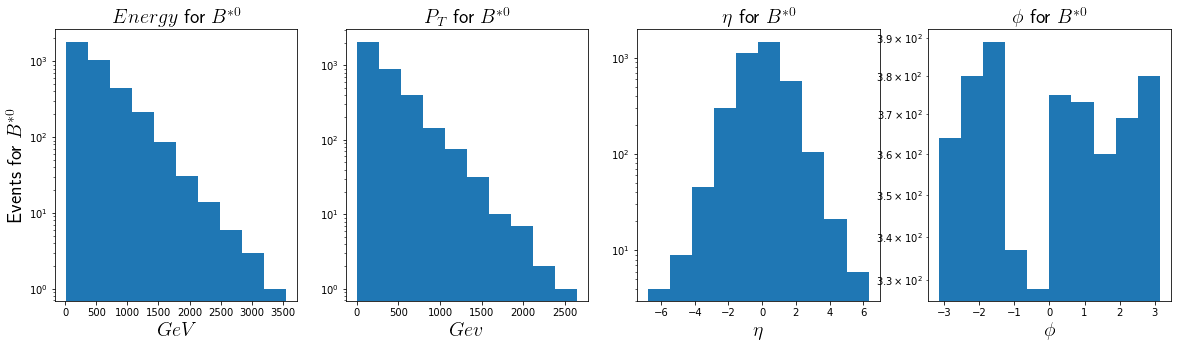

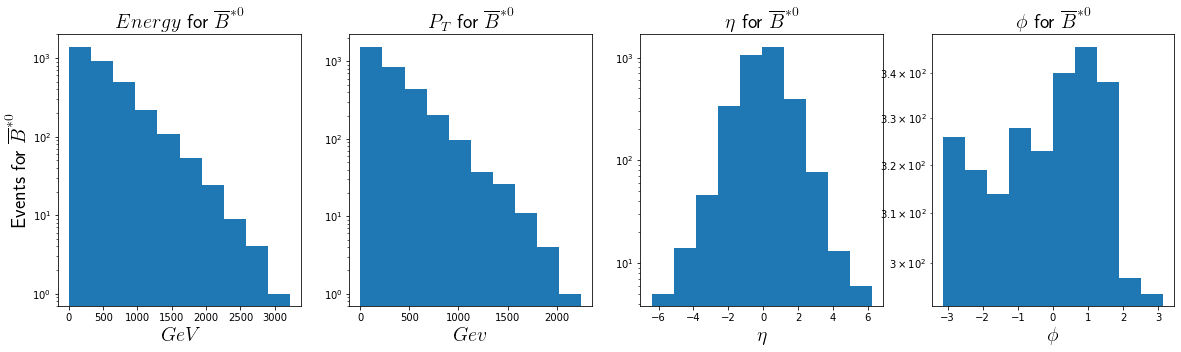

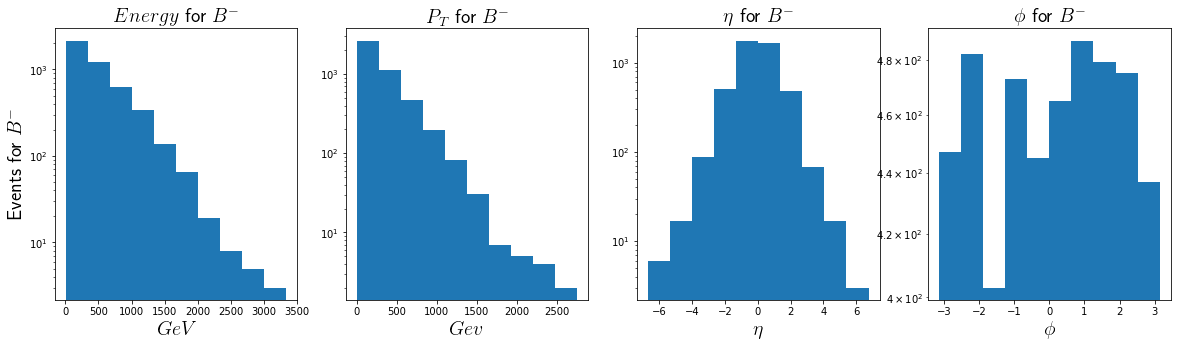

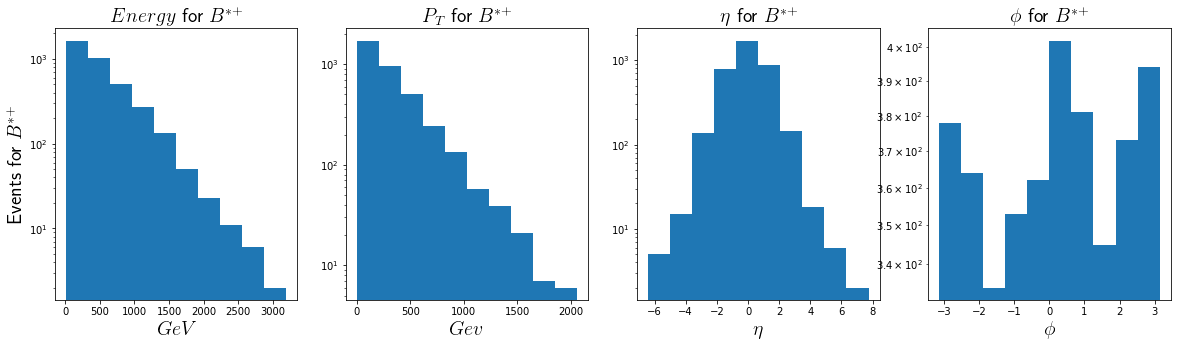

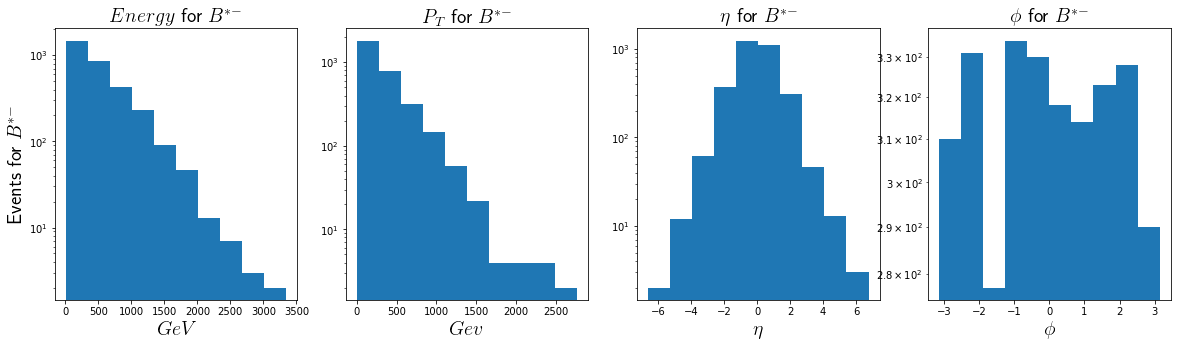

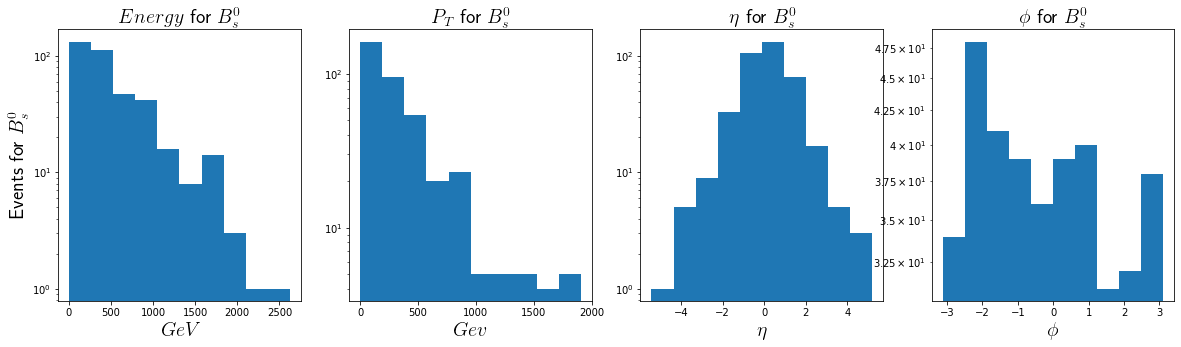

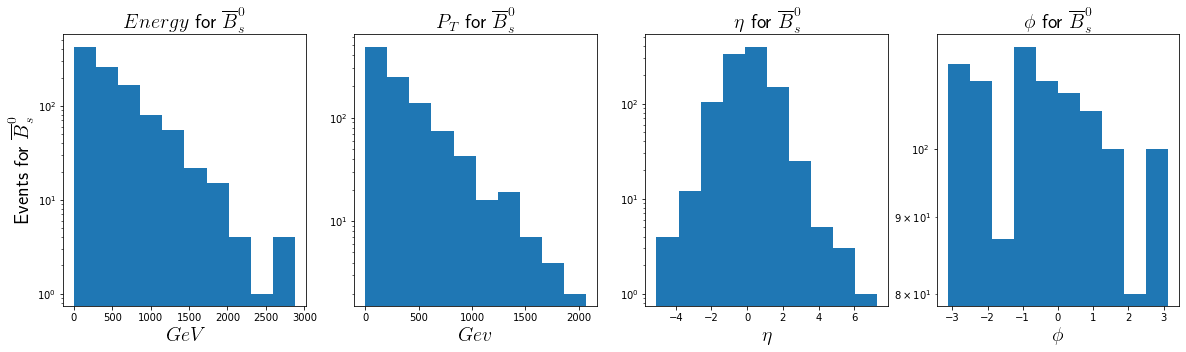

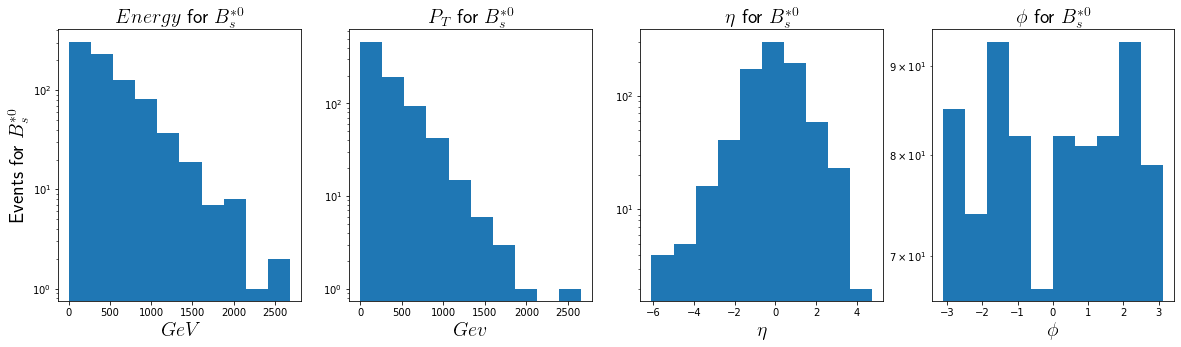

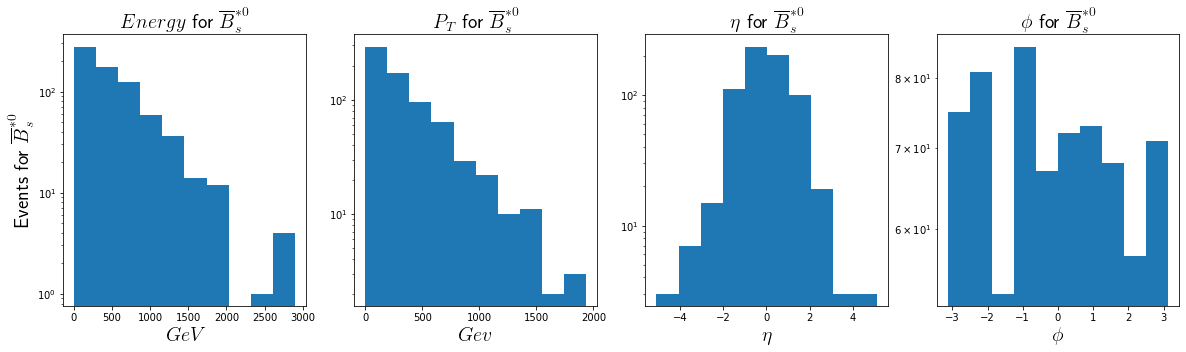

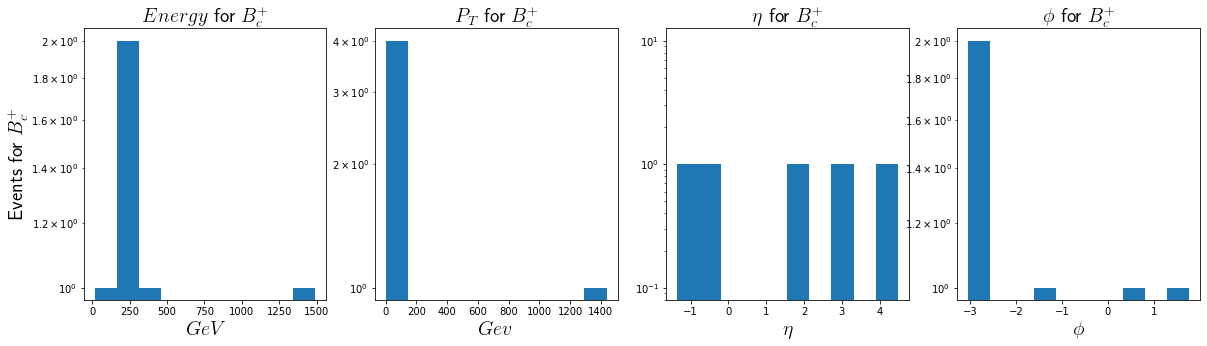

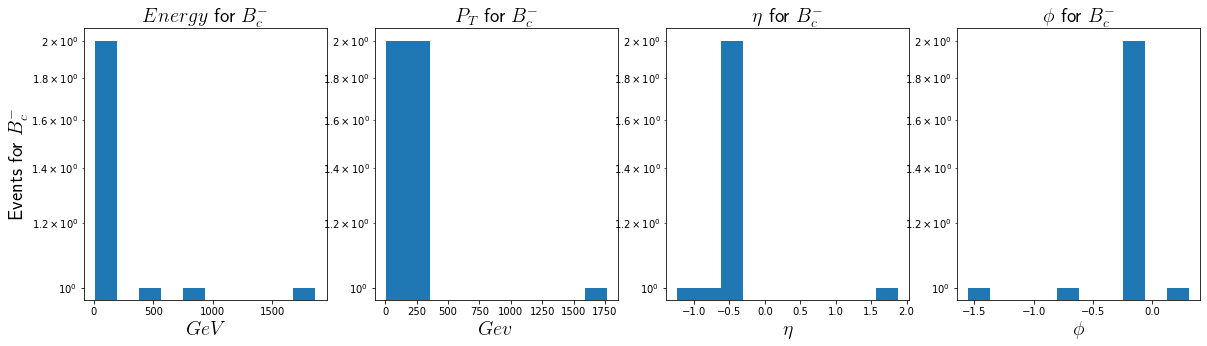

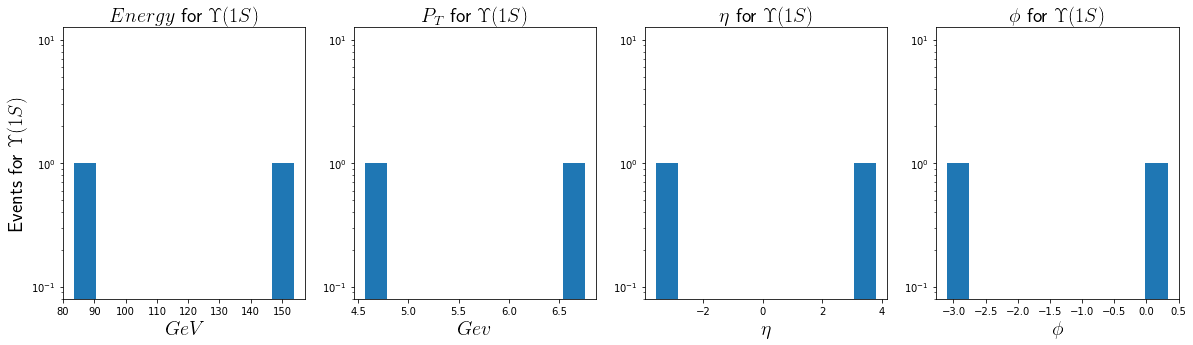

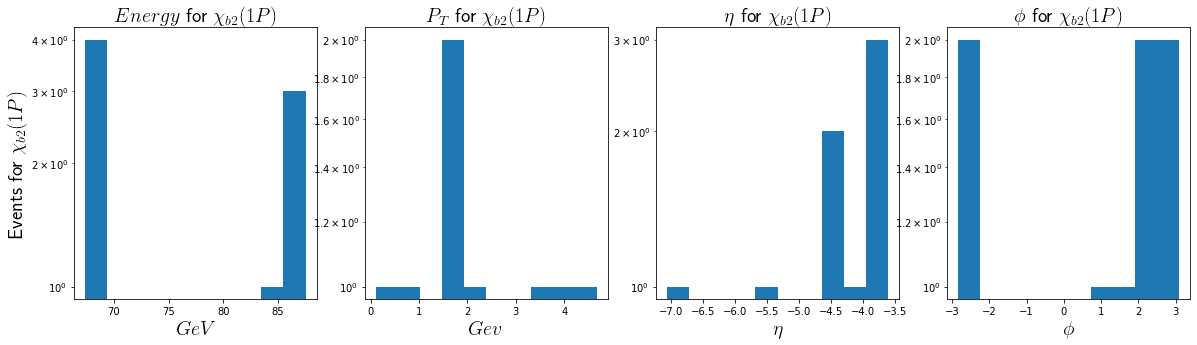

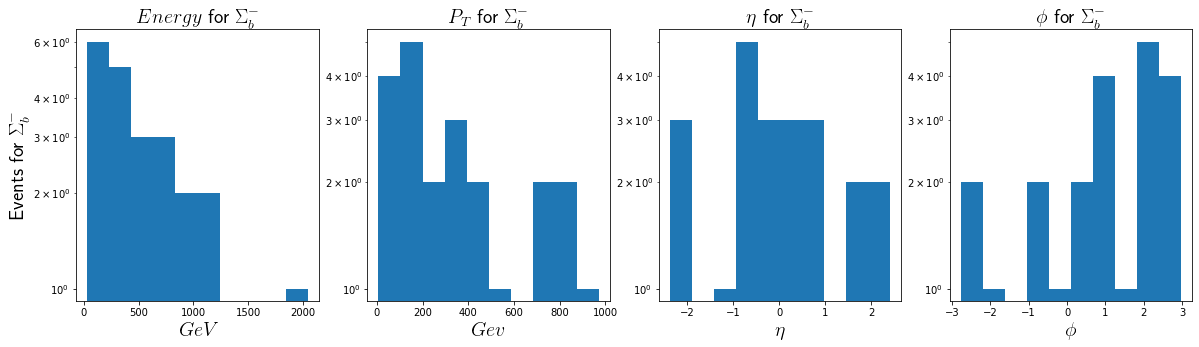

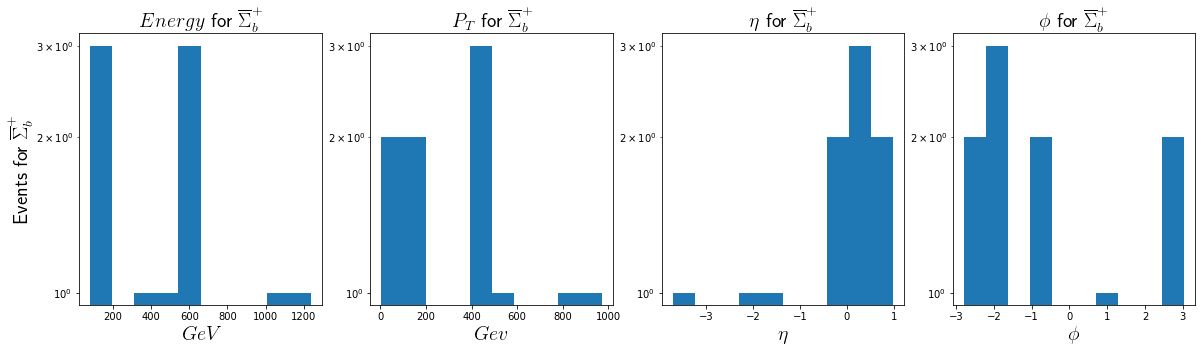

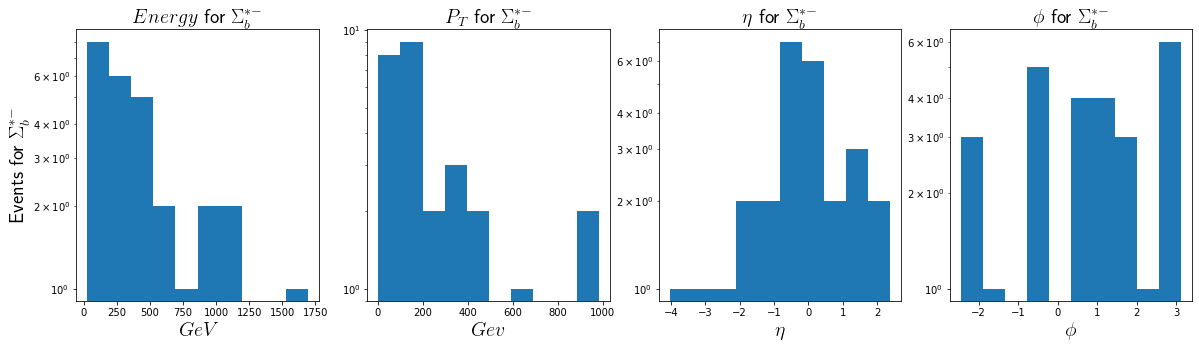

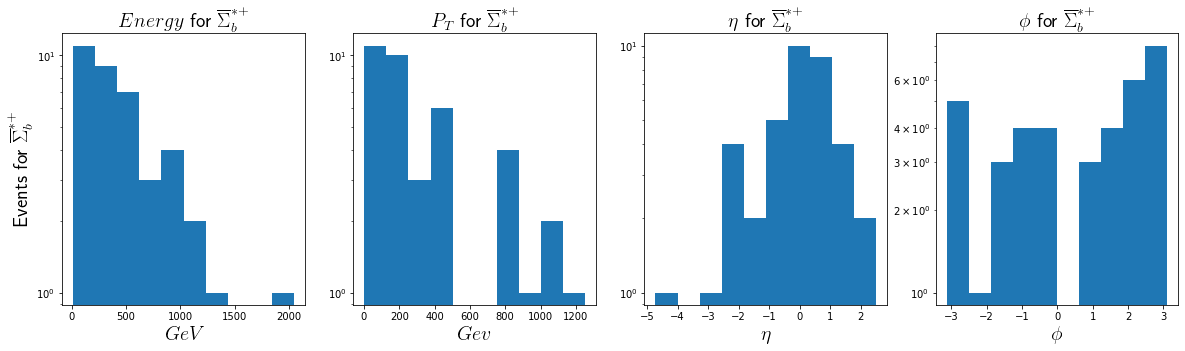

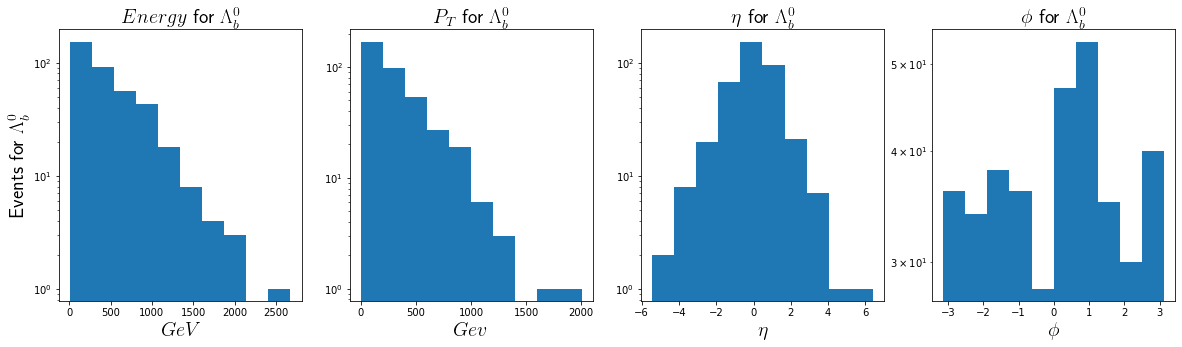

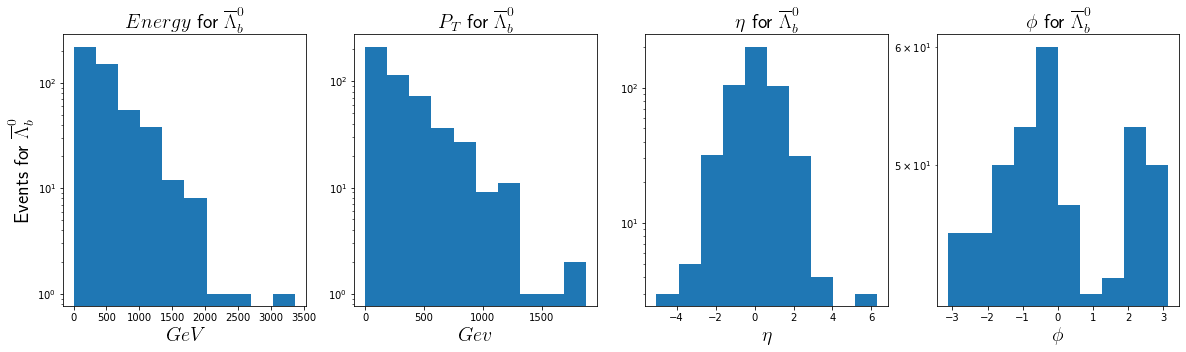

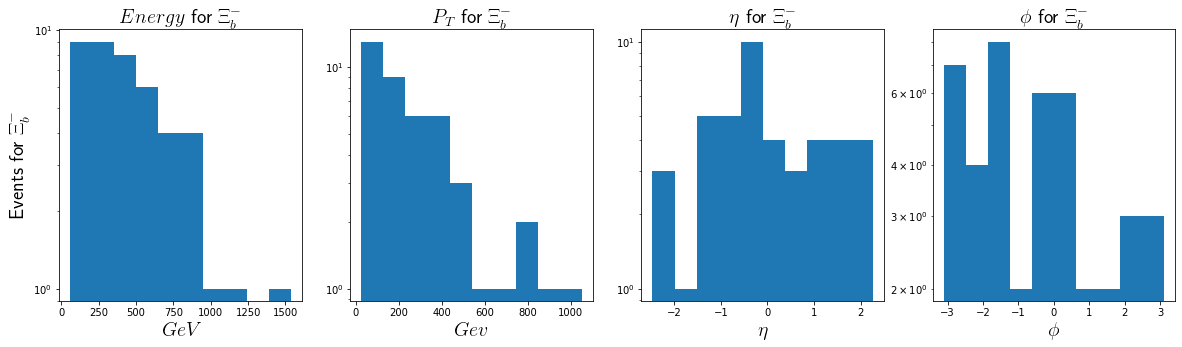

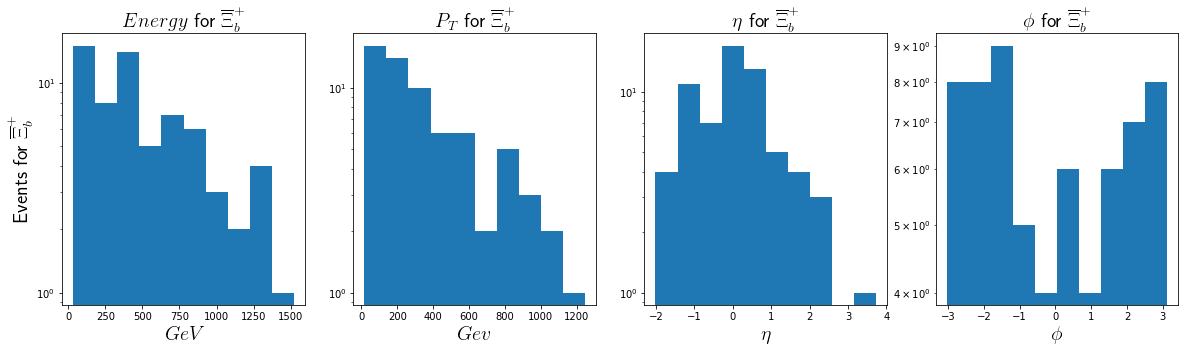

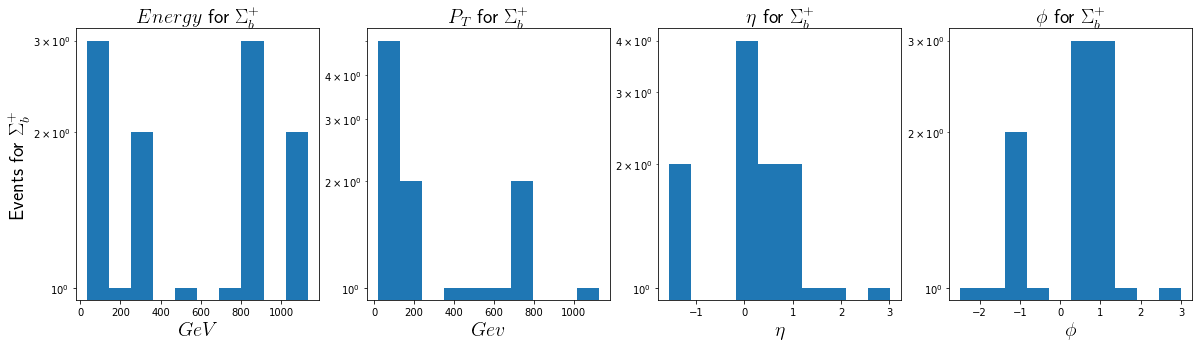

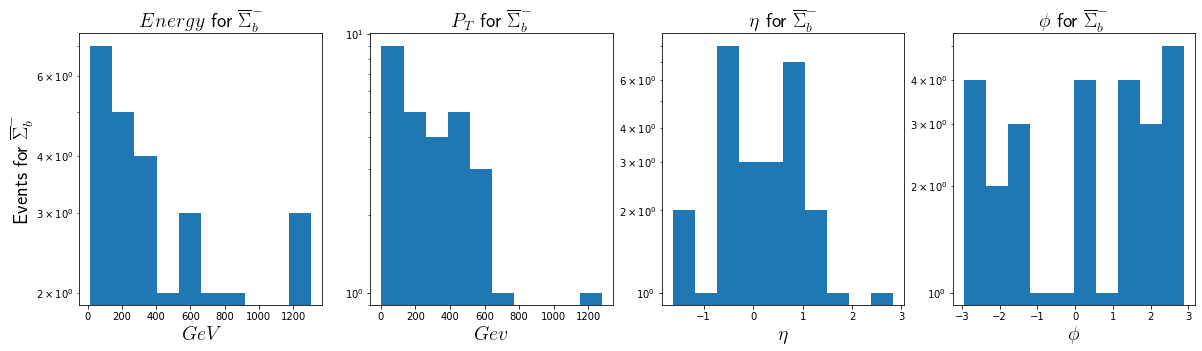

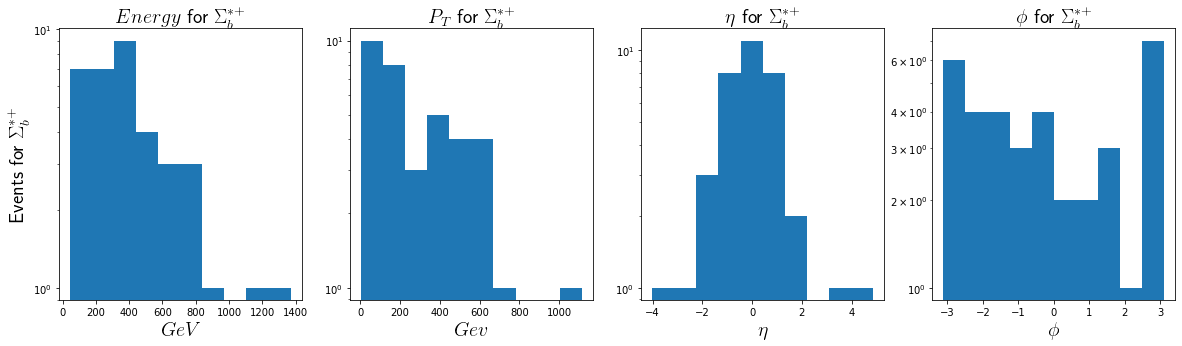

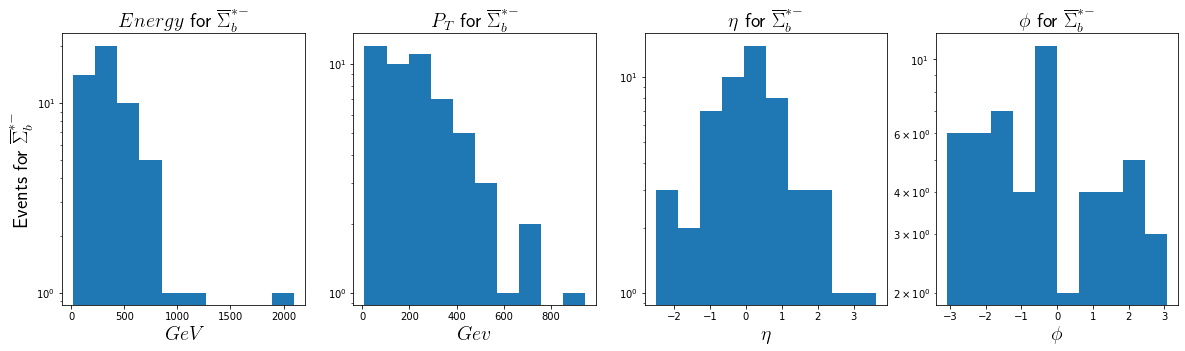

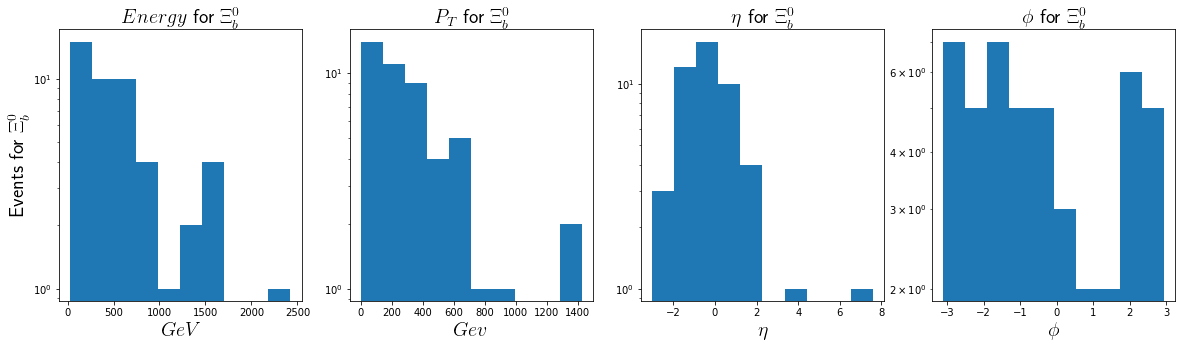

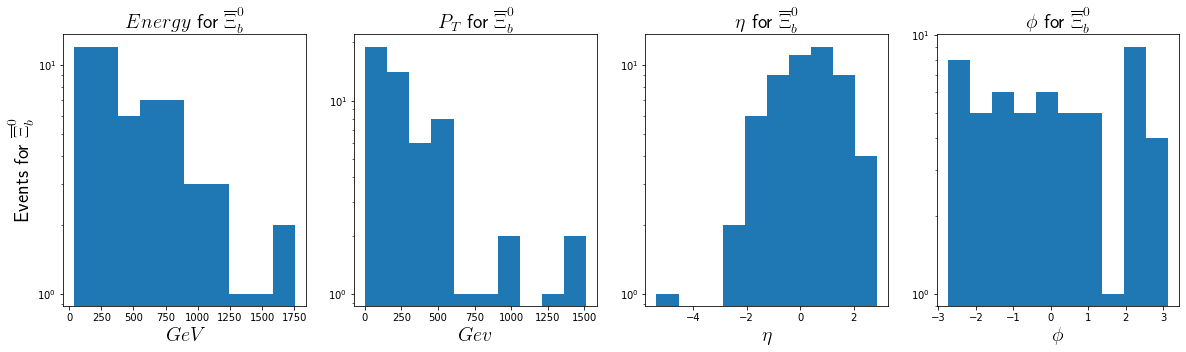

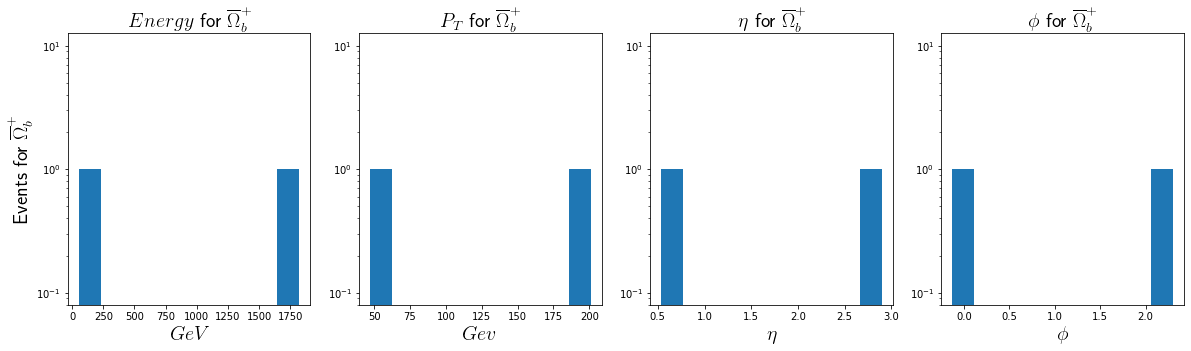

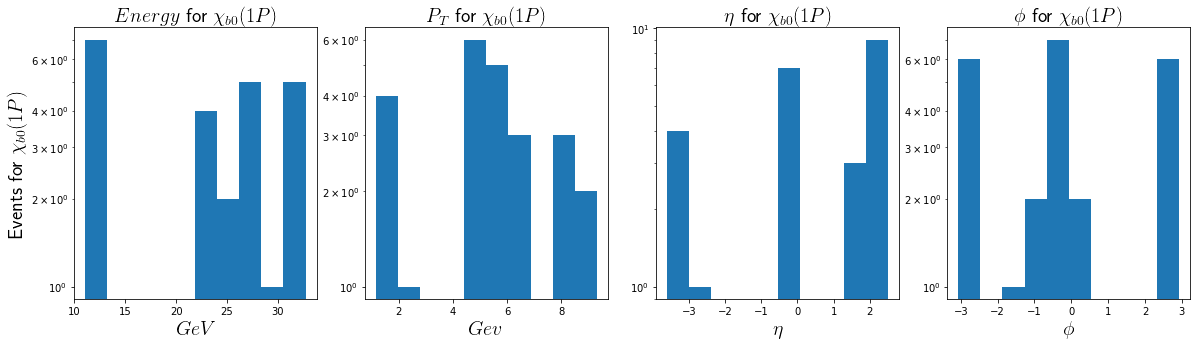

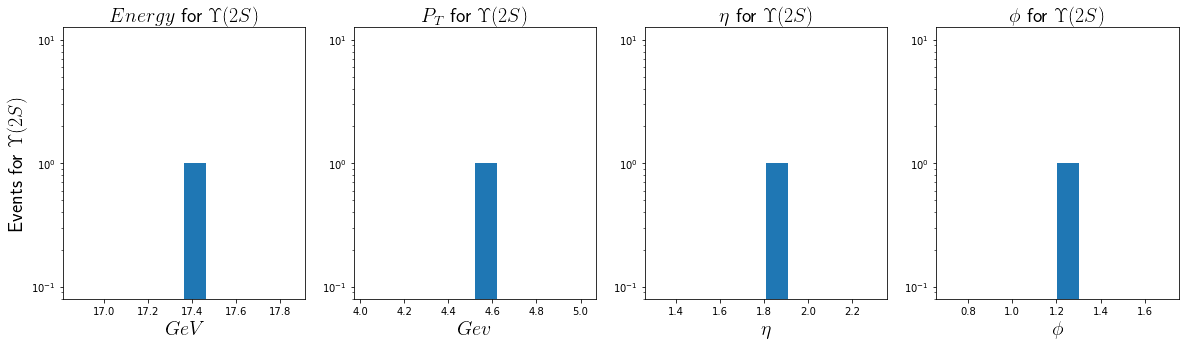

In [43]:
pdgids = list(map(lambda a: int(a.pdgid), Particle.finditer(lambda p: p.pdgid.is_hadron and (p.pdgid.has_bottom)))) #really fucky way of getting pids of B mesons
ctawk = ct_100.Particle

fields = ["E", "PT", "Eta", "Phi"]
x_axis = ["$GeV$", "$Gev$", "$\eta$", "$\phi$"]
titles = ["$Energy$ for ", "$P_{T}$ for ", "$\eta$ for ", "$\phi$ for "]

for pdgid in pdgids:
    mask = (ctawk.PID == pdgid)
    if ak.sum(mask) != 0:
        fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))
        fig[1][0].set_ylabel('Events for ' + '$' + Particle.from_pdgid(PDGID(pdgid)).latex_name + '$', usetex = True, fontsize = 20)
        for i in range(len(fields)):
            fig[1][i].hist(ak.flatten(ctawk[mask][fields[i]]), log = True)
            fig[1][i].set_title(titles[i] + ' $' + Particle.from_pdgid(PDGID(pdgid)).latex_name + '$', usetex = True, fontsize = 20)
            fig[1][i].set_xlabel(x_axis[i], fontsize = 20, usetex = True)
            #fig[1][i].set_ylim([0, 1])
        fig[0].show()


### ct_10

/tmp/ipykernel_10497/770205577.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))


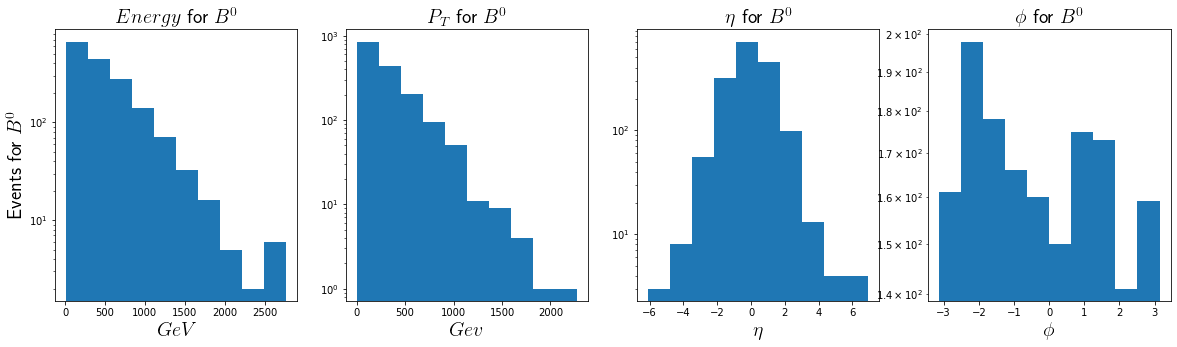

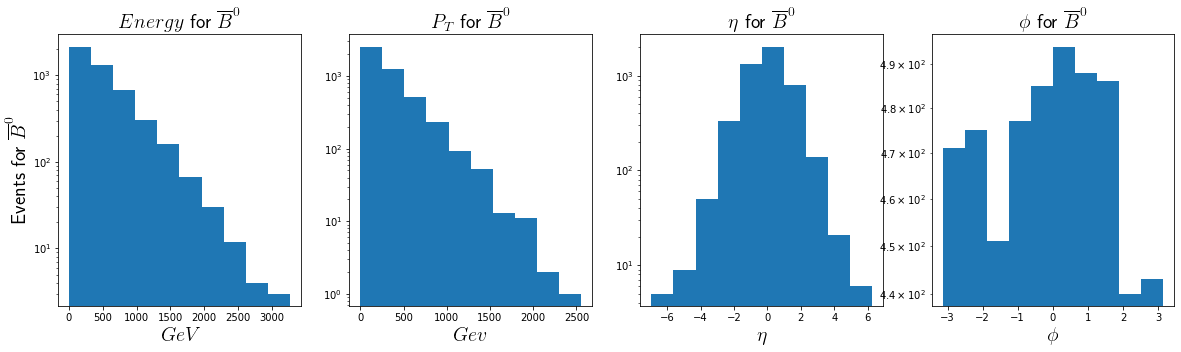

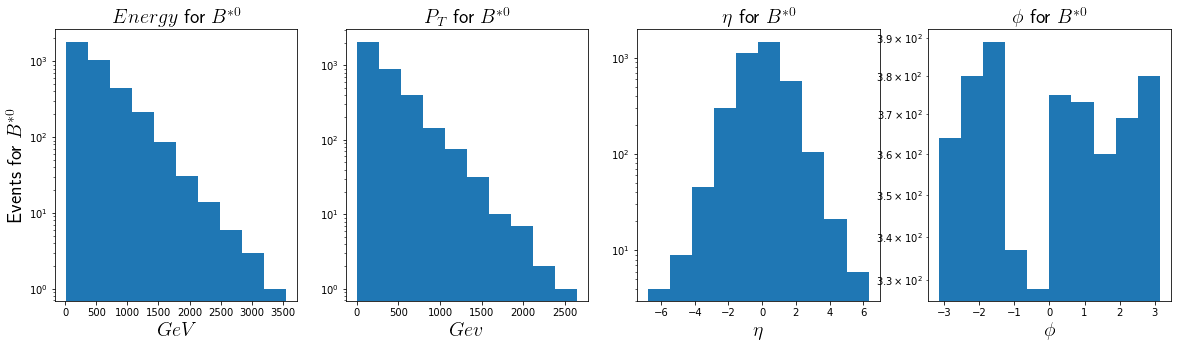

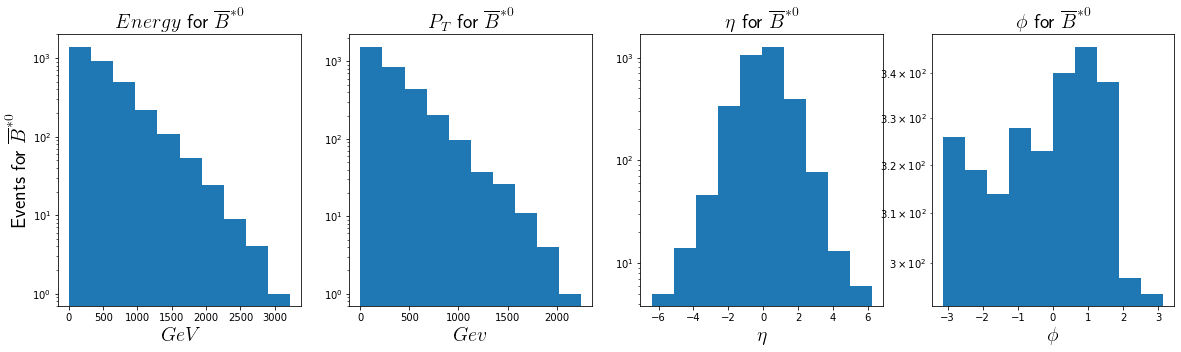

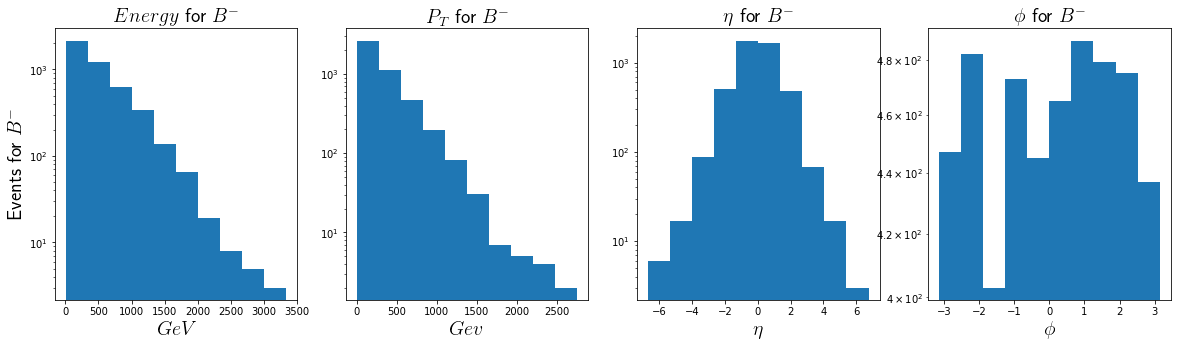

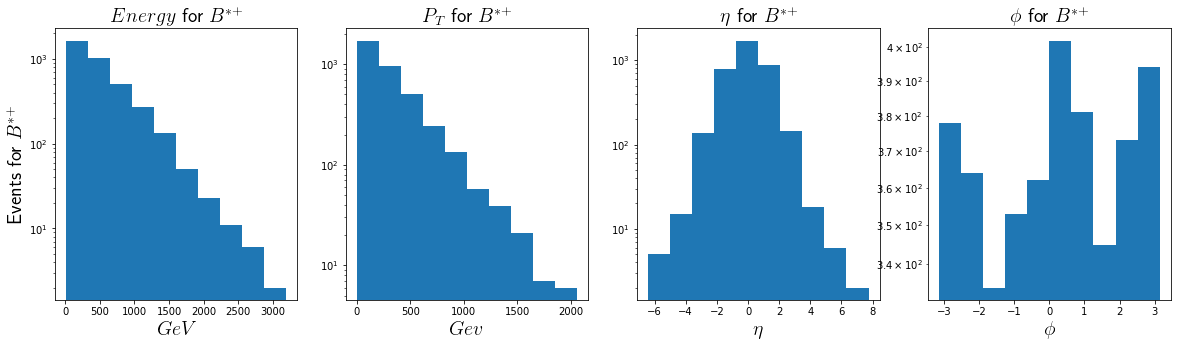

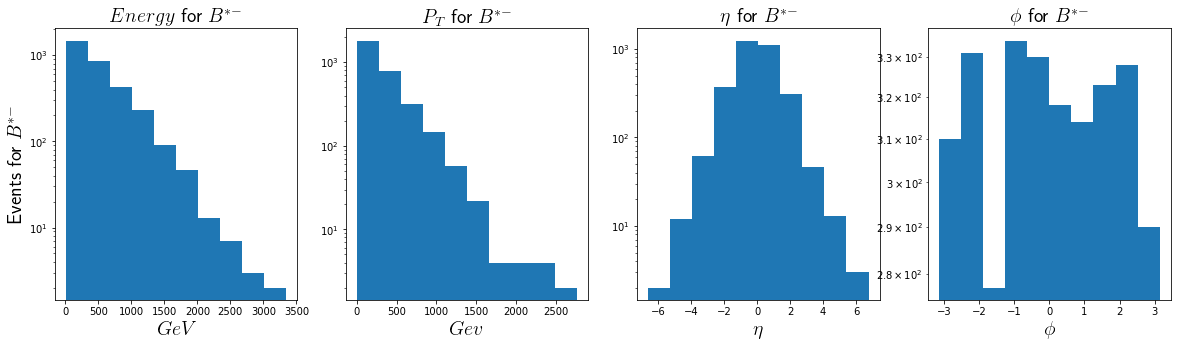

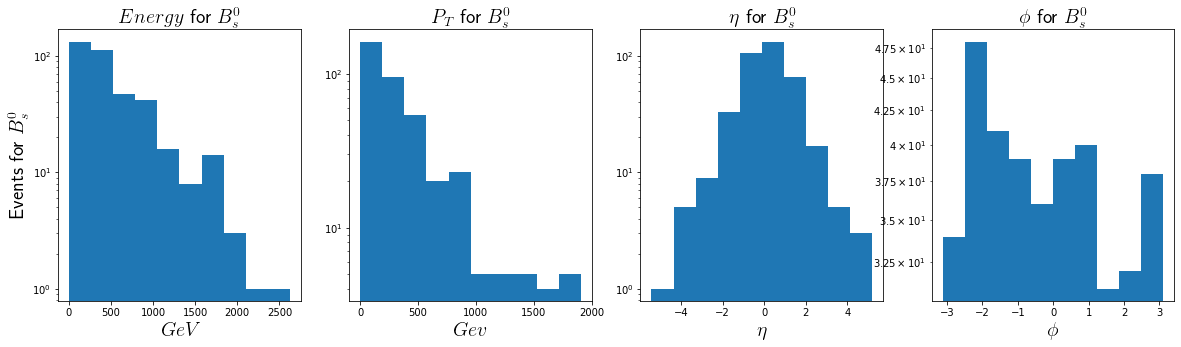

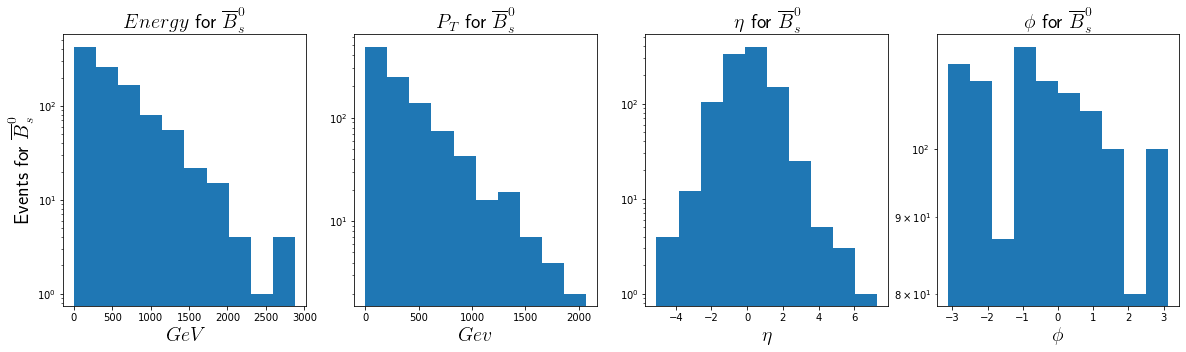

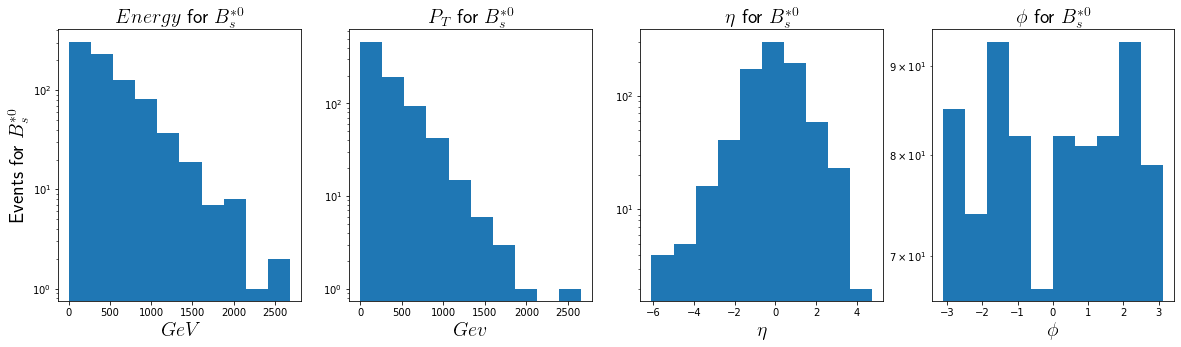

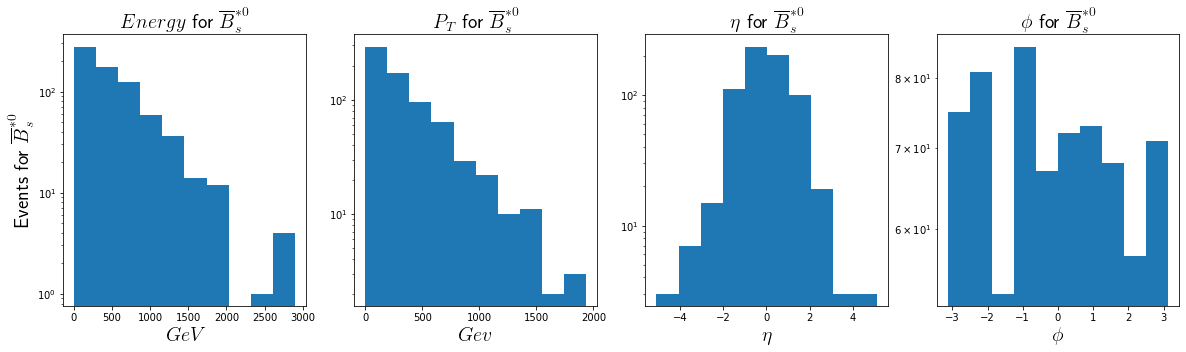

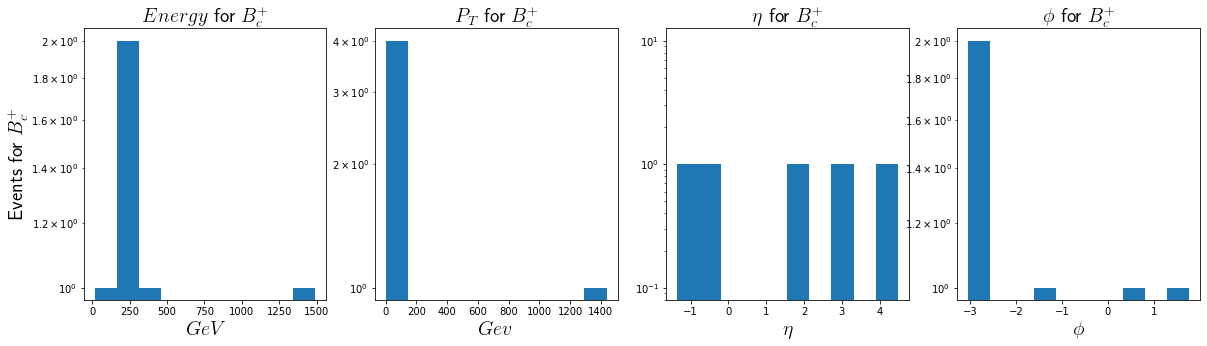

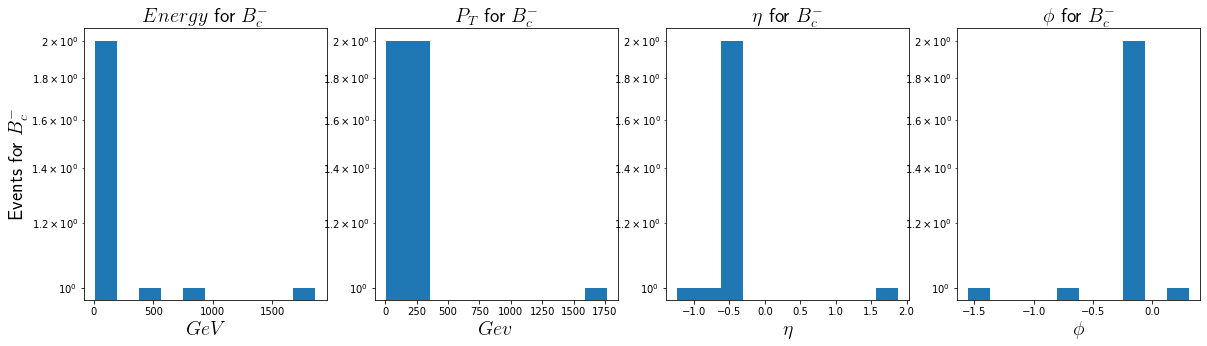

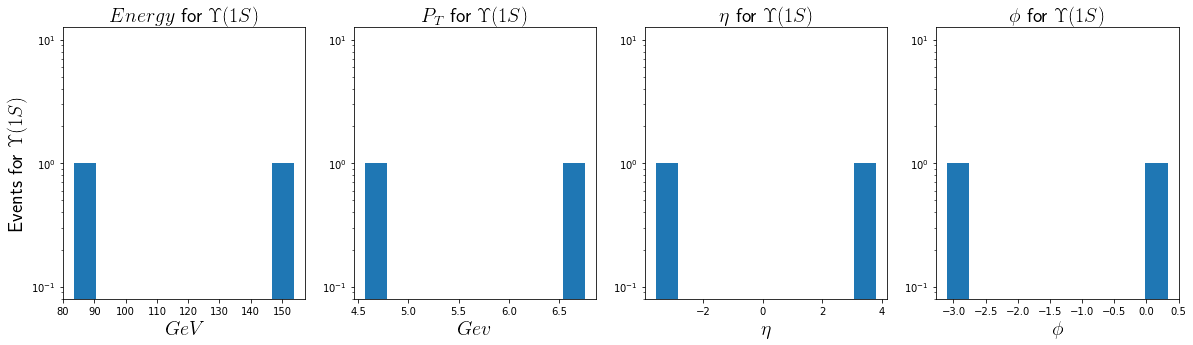

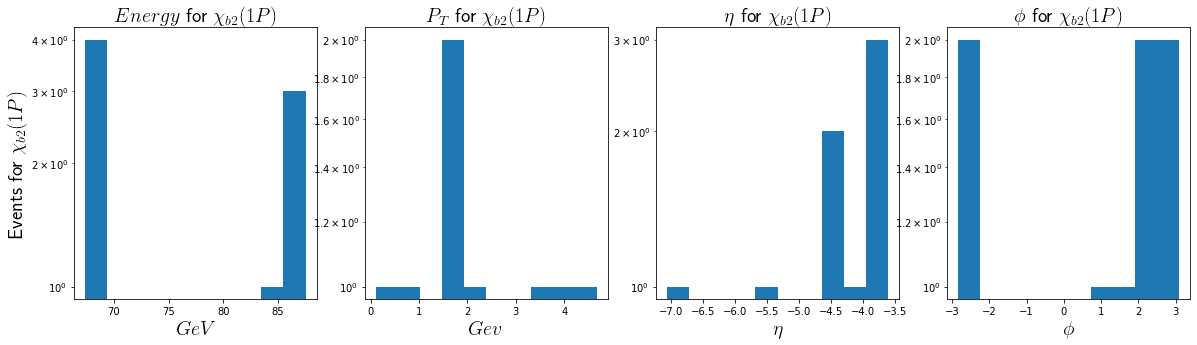

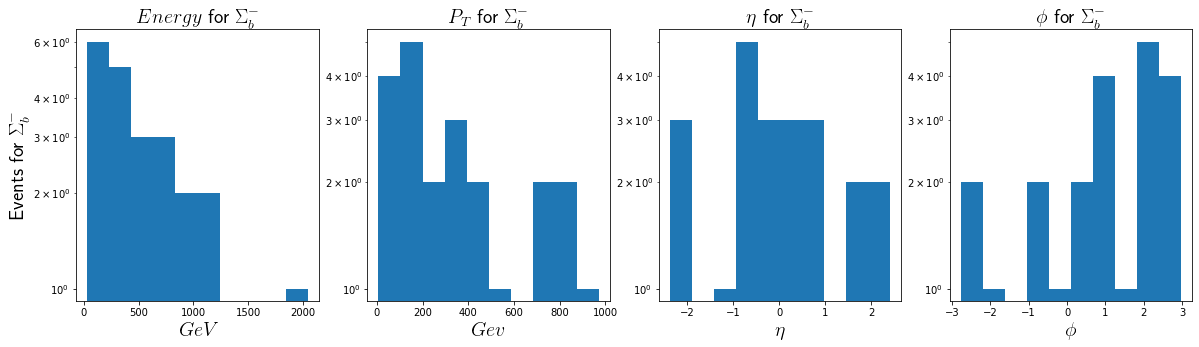

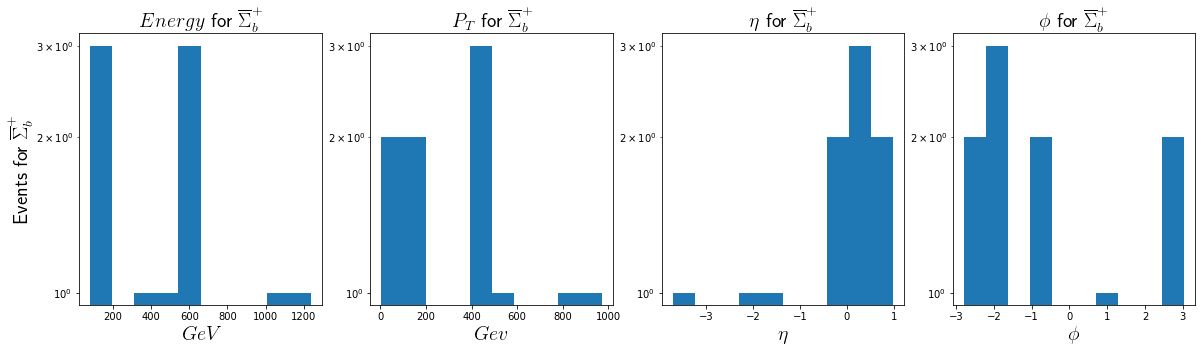

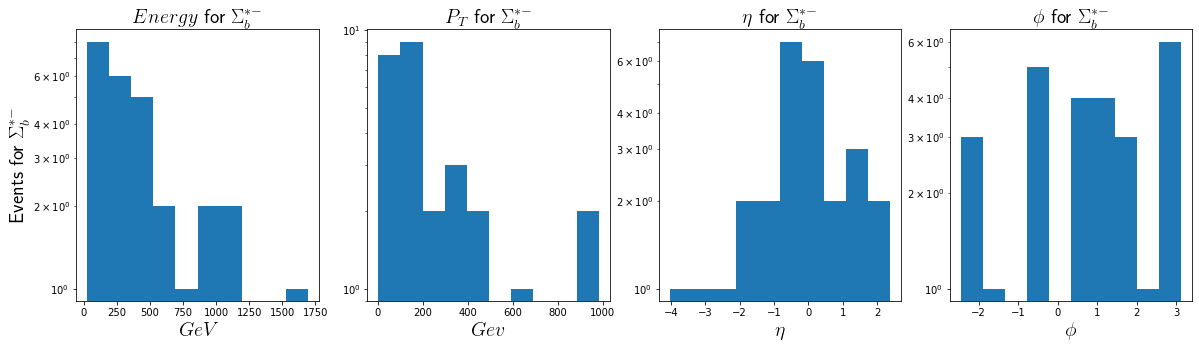

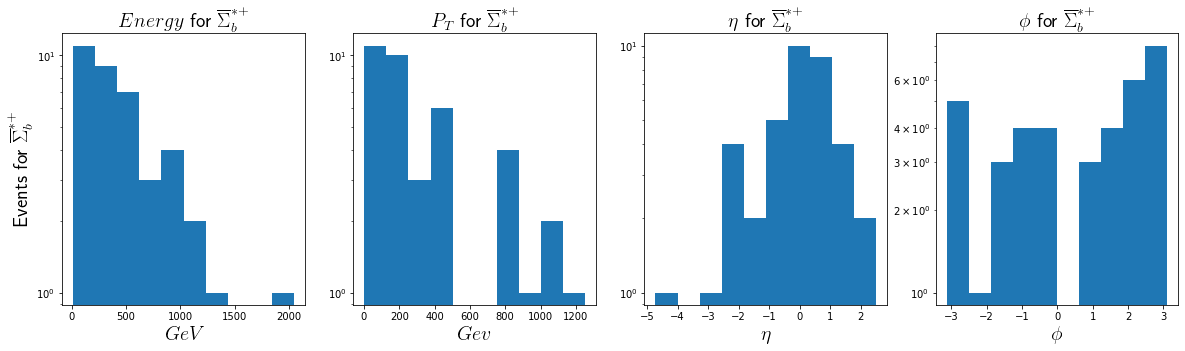

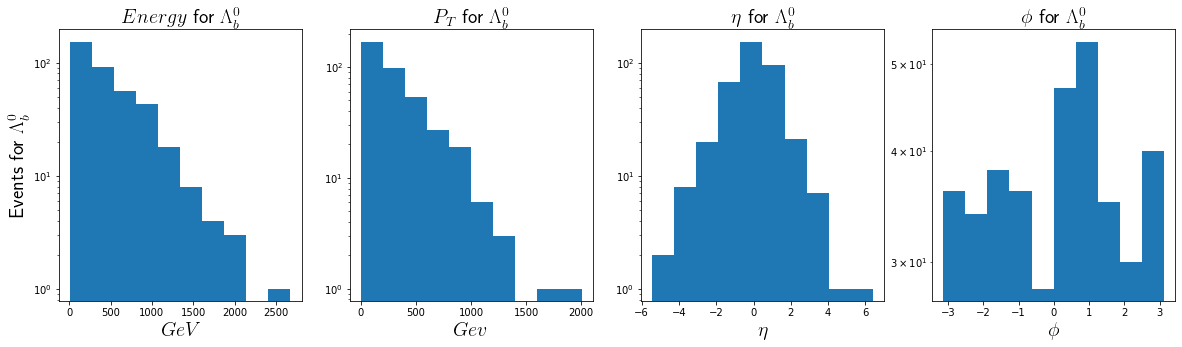

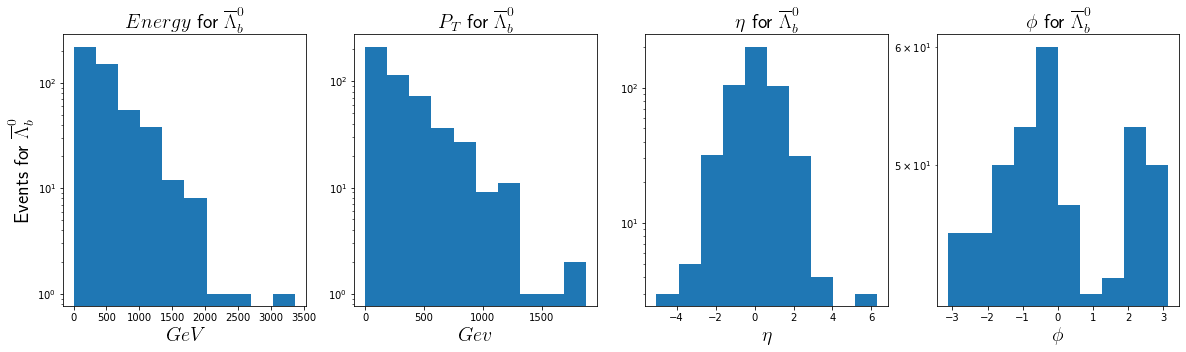

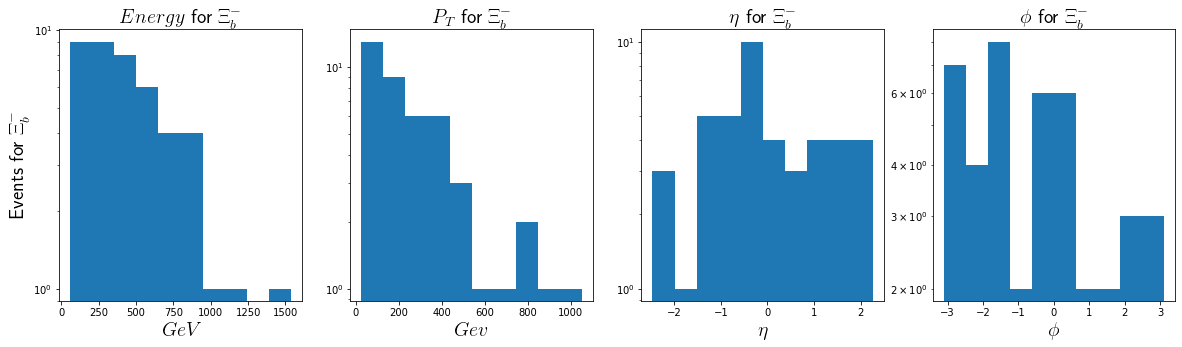

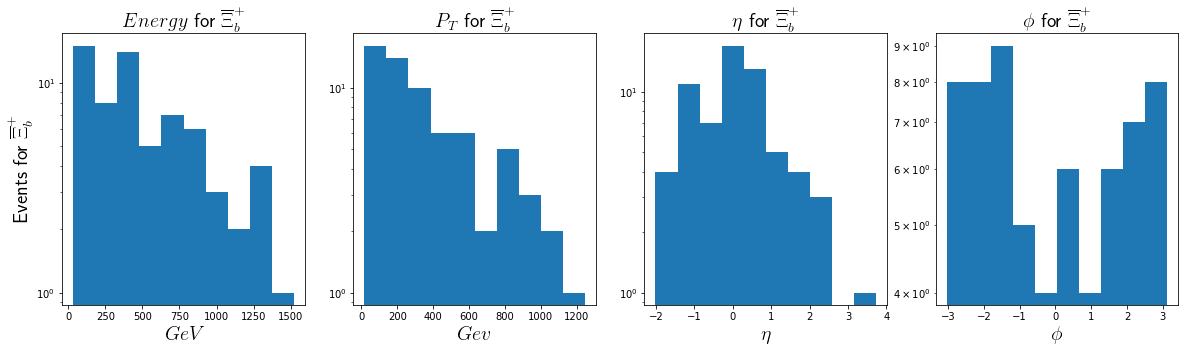

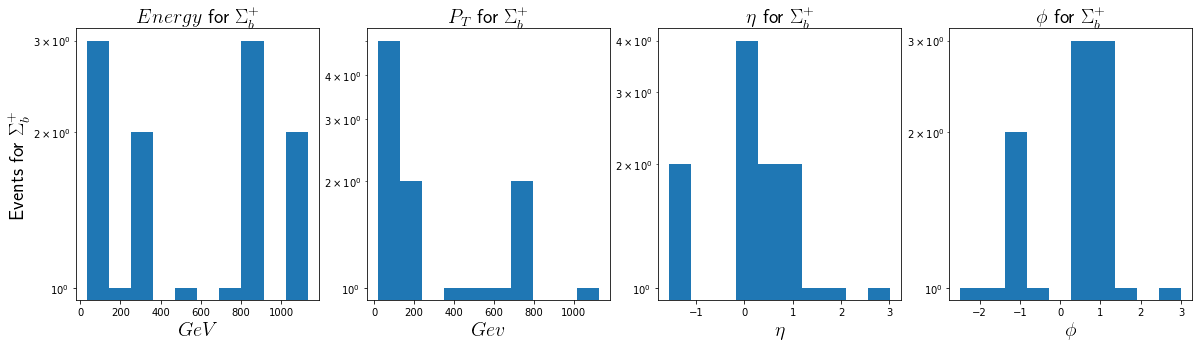

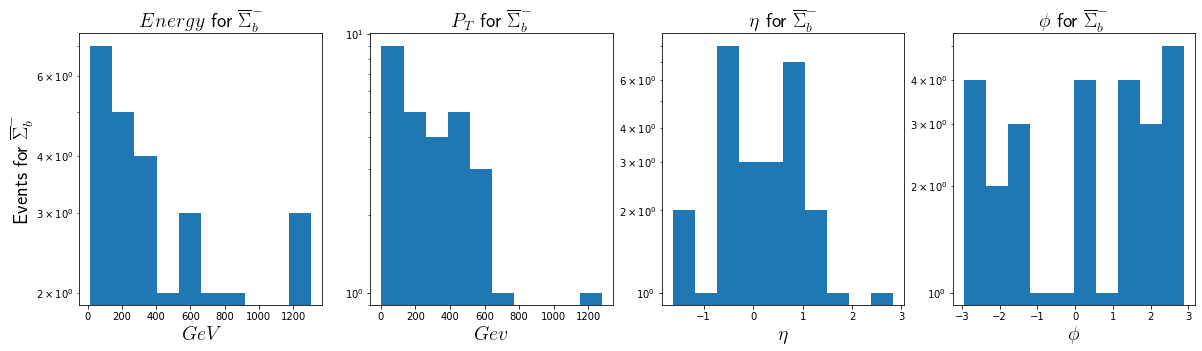

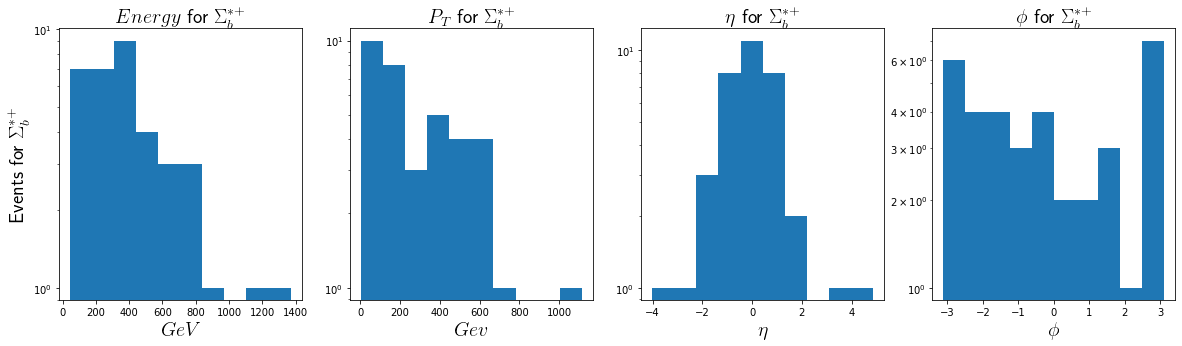

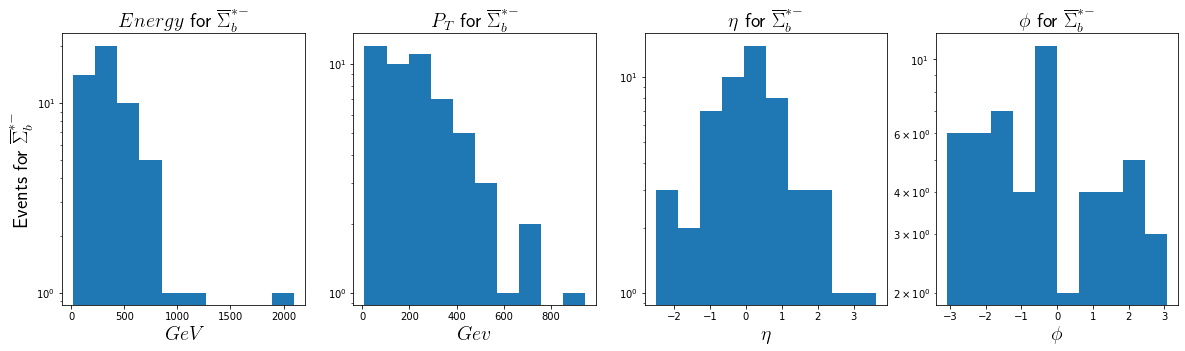

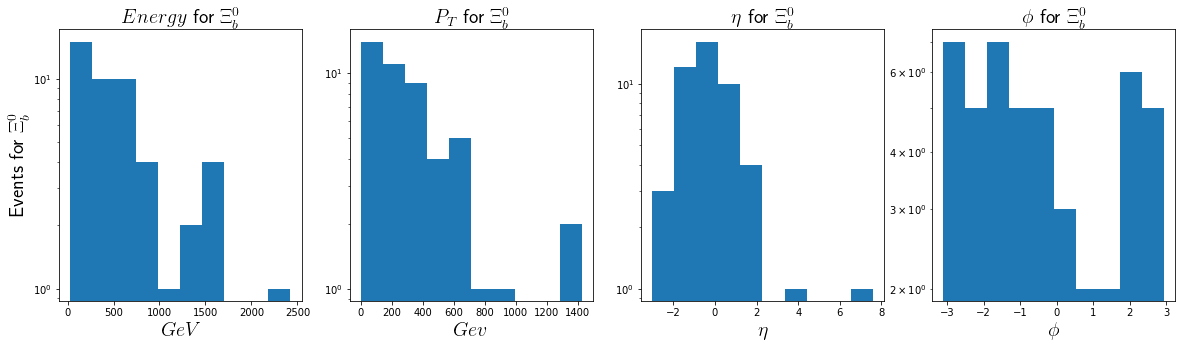

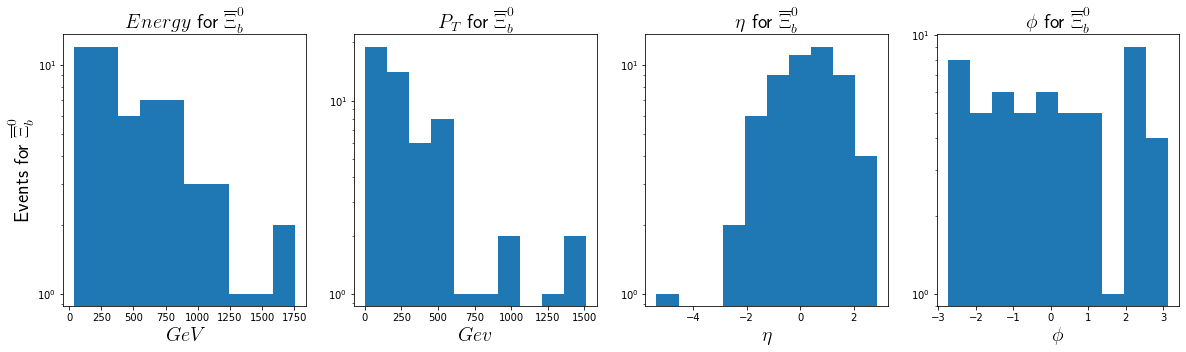

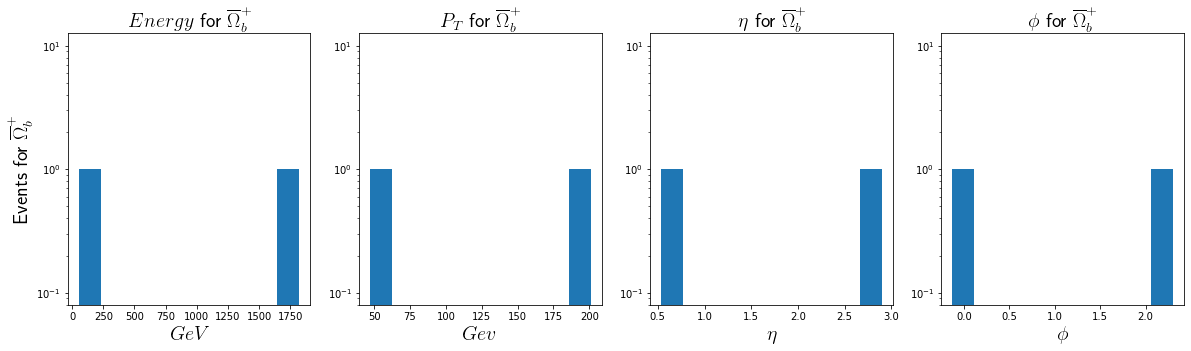

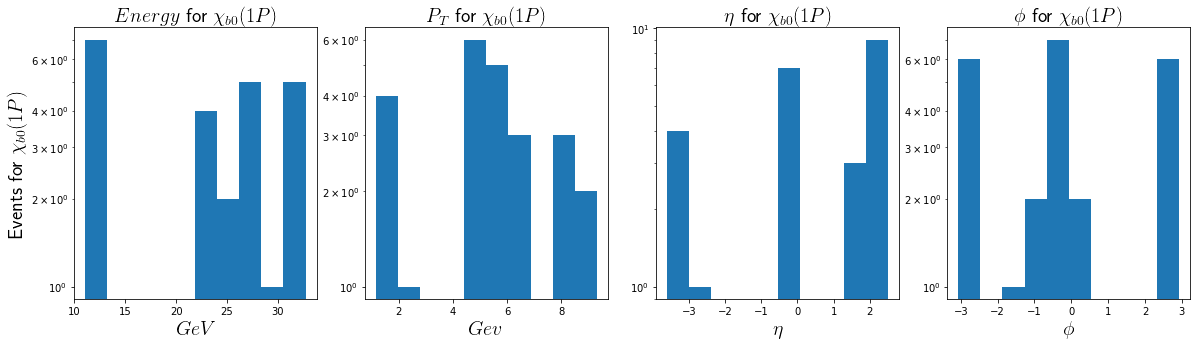

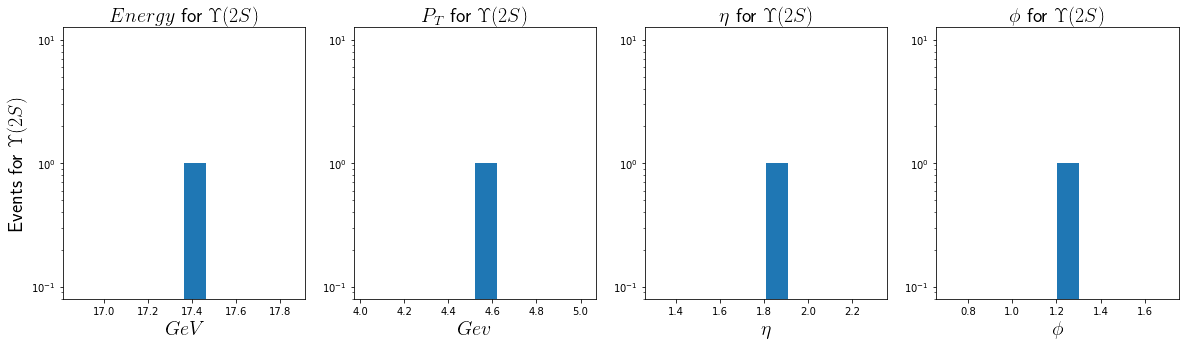

In [44]:
pdgids = list(map(lambda a: int(a.pdgid), Particle.finditer(lambda p: p.pdgid.is_hadron and (p.pdgid.has_bottom)))) #really fucky way of getting pids of B mesons
ctawk = ct_10.Particle

fields = ["E", "PT", "Eta", "Phi"]
x_axis = ["$GeV$", "$Gev$", "$\eta$", "$\phi$"]
titles = ["$Energy$ for ", "$P_{T}$ for ", "$\eta$ for ", "$\phi$ for "]

for pdgid in pdgids:
    mask = (ctawk.PID == pdgid)
    if ak.sum(mask) != 0:
        fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))
        fig[1][0].set_ylabel('Events for ' + '$' + Particle.from_pdgid(PDGID(pdgid)).latex_name + '$', usetex = True, fontsize = 20)
        for i in range(len(fields)):
            fig[1][i].hist(ak.flatten(ctawk[mask][fields[i]]), log = True)
            fig[1][i].set_title(titles[i] + ' $' + Particle.from_pdgid(PDGID(pdgid)).latex_name + '$', usetex = True, fontsize = 20)
            fig[1][i].set_xlabel(x_axis[i], fontsize = 20, usetex = True)
            #fig[1][i].set_ylim([0, 1])
        fig[0].show()


## LLP energy, pt, eta, phi, lab frame decay distance, rest frame decay distance

### ct_10000

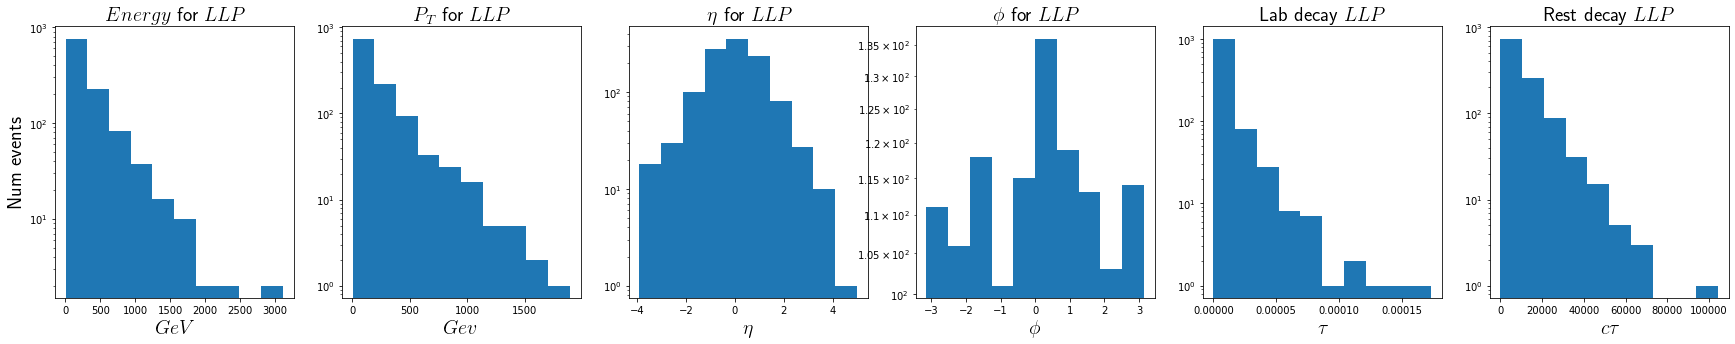

ctau ≈ 9914.793118353786


In [45]:
pdgid = 1500001
ctawk = ct_10000.Particle

fields = ["E", "PT", "Eta", "Phi", "decayT", "ctau"]
x_axis = ["$GeV$", "$Gev$", "$\eta$", "$\phi$", "$\\tau$", "$c\\tau$"]
titles = ["$Energy$ for ", "$P_{T}$ for ", "$\eta$ for ", "$\phi$ for ", "Lab decay", "Rest decay"]

mask = (ctawk.PID == pdgid)
if ak.sum(mask) != 0:
    fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))
    fig[1][0].set_ylabel('Num events', usetex = True, fontsize = 20)
    for i in range(len(fields)):
        hist = fig[1][i].hist(ak.flatten(ctawk[mask][fields[i]]), log = True)
        fig[1][i].set_title(titles[i] + ' $LLP$', usetex = True, fontsize = 20)
        fig[1][i].set_xlabel(x_axis[i], fontsize = 20, usetex = True)
        #fig[1][i].set_ylim([0, 1])
    fig[0].show()
else:
    print("there's no llp here!")
plt.show()

elements = (hist[1][1:] + hist[1][:-1])/2
frequencies = hist[0]

newfrequencies = frequencies[frequencies !=0]
newelements = elements[frequencies !=0]

slope, intercept = np.polyfit(newelements, np.log(newfrequencies), deg = 1, w = newfrequencies)
print("ctau ≈ " + str(1/np.abs(slope)))


### ct_1000

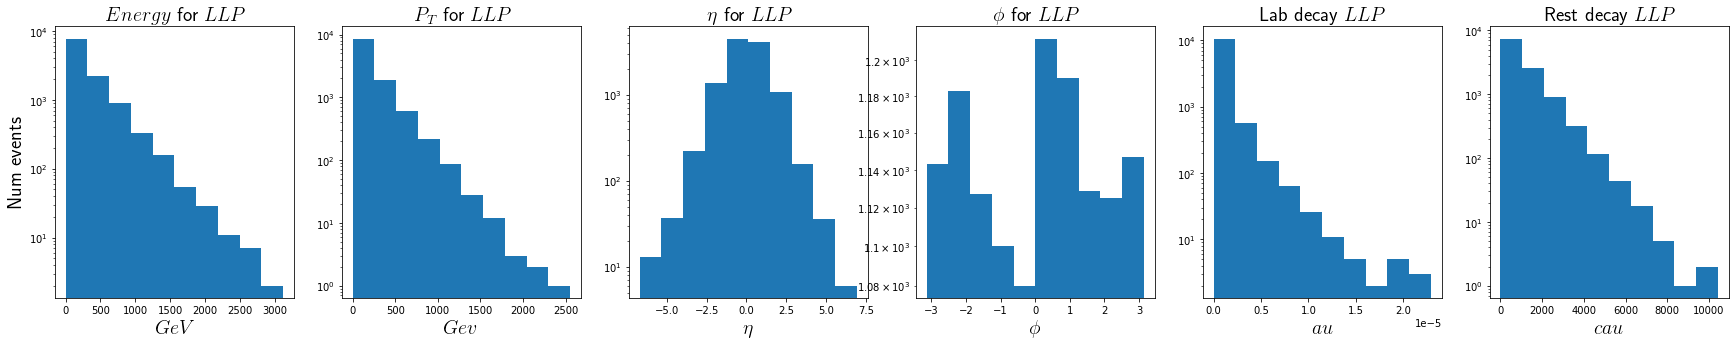

ctau ≈ 996.3548371730616


In [46]:
pdgid = 1500001
ctawk = ct_1000.Particle

fields = ["E", "PT", "Eta", "Phi", "decayT", "ctau"]
x_axis = ["$GeV$", "$Gev$", "$\eta$", "$\phi$", "$\tau$", "$c\tau$"]
titles = ["$Energy$ for ", "$P_{T}$ for ", "$\eta$ for ", "$\phi$ for ", "Lab decay", "Rest decay"]

mask = (ctawk.PID == pdgid)
if ak.sum(mask) != 0:
    fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))
    fig[1][0].set_ylabel('Num events', usetex = True, fontsize = 20)
    for i in range(len(fields)):
        hist = fig[1][i].hist(ak.flatten(ctawk[mask][fields[i]]), log = True)
        fig[1][i].set_title(titles[i] + ' $LLP$', usetex = True, fontsize = 20)
        fig[1][i].set_xlabel(x_axis[i], fontsize = 20, usetex = True)
        #fig[1][i].set_ylim([0, 1])
    fig[0].show()
else:
    print("there's no llp here!")
plt.show()

elements = (hist[1][1:] + hist[1][:-1])/2
frequencies = hist[0]

newfrequencies = frequencies[frequencies !=0]
newelements = elements[frequencies !=0]

slope, intercept = np.polyfit(newelements, np.log(newfrequencies), deg = 1, w = newfrequencies)
print("ctau ≈ " + str(1/np.abs(slope)))


### ct_100

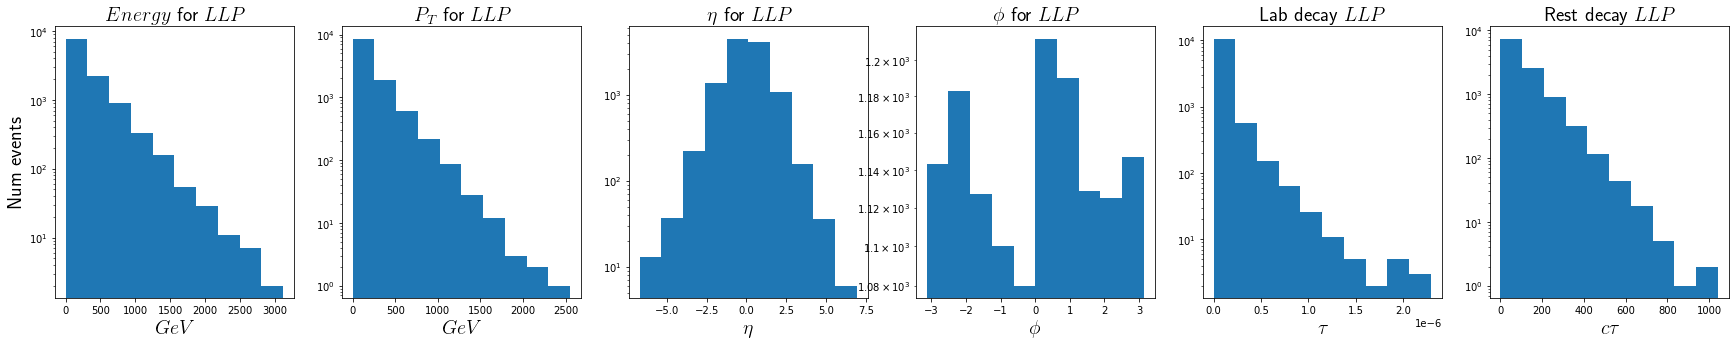

ctau ≈ 99.63548337812956


In [47]:
pdgid = 1500001
ctawk = ct_100.Particle

fields = ["E", "PT", "Eta", "Phi", "decayT", "ctau"]
x_axis = ["$GeV$", "$GeV$", "$\eta$", "$\phi$", "$\\tau$", "$c\\tau$"]
titles = ["$Energy$ for ", "$P_{T}$ for ", "$\eta$ for ", "$\phi$ for ", "Lab decay", "Rest decay"]

mask = (ctawk.PID == pdgid)
if ak.sum(mask) != 0:
    fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))
    fig[1][0].set_ylabel('Num events', usetex = True, fontsize = 20)
    for i in range(len(fields)):
        hist = fig[1][i].hist(ak.flatten(ctawk[mask][fields[i]]), log = True)
        fig[1][i].set_title(titles[i] + ' $LLP$', usetex = True, fontsize = 20)
        fig[1][i].set_xlabel(x_axis[i], fontsize = 20, usetex = True)
        #fig[1][i].set_ylim([0, 1])
    fig[0].show()
else:
    print("there's no llp here!")
plt.show()

elements = (hist[1][1:] + hist[1][:-1])/2
frequencies = hist[0]

newfrequencies = frequencies[frequencies !=0]
newelements = elements[frequencies !=0]

slope, intercept = np.polyfit(newelements, np.log(newfrequencies), deg = 1, w = newfrequencies)
print("ctau ≈ " + str(1/np.abs(slope)))


### ct_10

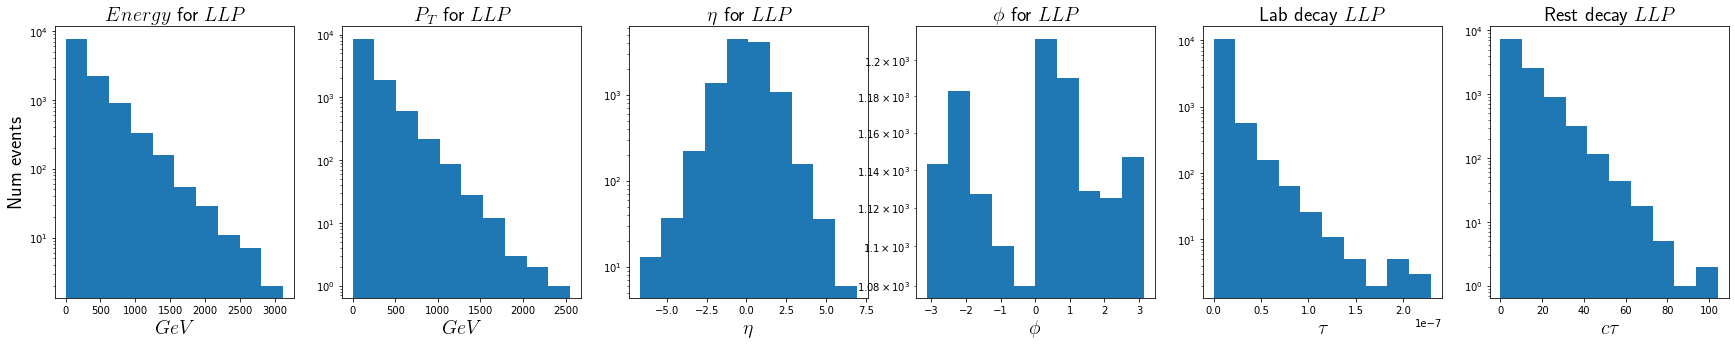

ctau ≈ 9.963547687924791


In [48]:
pdgid = 1500001
ctawk = ct_10.Particle

fields = ["E", "PT", "Eta", "Phi", "decayT", "ctau"]
x_axis = ["$GeV$", "$GeV$", "$\eta$", "$\phi$", "$\\tau$", "$c\\tau$"]
titles = ["$Energy$ for ", "$P_{T}$ for ", "$\eta$ for ", "$\phi$ for ", "Lab decay", "Rest decay"]

mask = (ctawk.PID == pdgid)
if ak.sum(mask) != 0:
    fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))
    fig[1][0].set_ylabel('Num events', usetex = True, fontsize = 20)
    for i in range(len(fields)):
        hist = fig[1][i].hist(ak.flatten(ctawk[mask][fields[i]]), log = True)
        fig[1][i].set_title(titles[i] + ' $LLP$', usetex = True, fontsize = 20)
        fig[1][i].set_xlabel(x_axis[i], fontsize = 20, usetex = True)
        #fig[1][i].set_ylim([0, 1])
    fig[0].show()
else:
    print("there's no llp here!")
plt.show()

elements = (hist[1][1:] + hist[1][:-1])/2
frequencies = hist[0]

newfrequencies = frequencies[frequencies !=0]
newelements = elements[frequencies !=0]

slope, intercept = np.polyfit(newelements, np.log(newfrequencies), deg = 1, w = newfrequencies)
print("ctau ≈ " + str(1/np.abs(slope)))


### check the acceptance of the muon system as a function of $c\tau$ TODO

### What's the typical energy fraction that the LLP carries from the B-hadron? TODO

## $\Delta R$ between LLP and Kaon (both coming from one of the B-hadrons) TODO

## Using the B-hadron that does not produce the LLP find it's the events that decay to muons. TODO

### Require the muon pt to be larger that 8 GeV and plot again the LLP kinematic variables TODO


## Now using the delphes module from check the LLP reconstruction efficiency when the LLP decays in the muon system. Todo

## Check if there is any jet in the vicinity of the LLP cluster using deltaR matching. TODO

### What's the typical energy of the jet that is match and how close are they to the LLP  in eta, phi. TODO

In [372]:
df = ak.to_pandas(events[0].Particle[["PID","D1","D2","M1","M2","Status","PT","Eta","Phi","ctau"]])

for i in range(len(df)):
    try: # dont do this at home
        df["PID"][i]= pt.from_pdgid(PID(df["PID"][i]).to_pdgid())
    except:
        print(df["PID"][i])
    
qgrid.show_grid(df)

1500001


/tmp/ipykernel_4265/2944105905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["PID"][i]= pt.from_pdgid(PID(df["PID"][i]).to_pdgid())


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [ ]:
shower = events[0].Particle #an event

tree = {}
for i in range(len(shower)):
    particle = shower[i]
    #d1 = particle.D1
    #d2 = particle.D2
    
    m1 = particle.M1
    m2 = particle.M2
    
    branch = {}
    
    if m1 != -1:
        branch[m1] = {}
    if m2 != -1:
        branch[m2] = {}
    #if d1 != -1:
    #    branch[d1] = {}
    #if d2 != -1:
    #    branch[d2] = {}
        
    
    tree[i] = branch

In [ ]:
T = nx.DiGraph(tree)
nx.draw_kamada_kawai(T, node_size = 10)